In [2]:
from CartPole import CartPole, _remap_angle, remap_angle, _loss, loss
import numpy as np
import matplotlib.pyplot as plt
import sobol_seq
import matplotlib.tri as tri

In [3]:
## main functions to define nonlinear model definitions

# function to return array of X,Y datapoints: list of typles (X, Y) where X and Y are numpy arrays of length 4
# Y currently set to the difference between new state and initial state
# if want_actions is True, datapoints generated will be of form (X, Y) where X is a numpy array of length 5 and Y is a numpy array of length 4
def make_array_of_XY_datapoints(num_datapoints, want_actions=False):

    # initialise instance of CartPole
    pendulum = CartPole()

    # create empty list into which (X,Y) datapoints will go
    datapoints = []

    # fill with num_datapoints number of (X,Y) datapoints
    for i in range(num_datapoints):
            
        # initialise random state
        cart_location = np.random.uniform(-9, 9)
        cart_velocity = np.random.uniform(-10, 10)
        pole_angle = np.random.uniform(-np.pi, np.pi)
        pole_velocity = np.random.uniform(-15, 15)
        action = np.random.uniform(-4, 4)
        X = np.array([cart_location, cart_velocity, pole_angle, pole_velocity])
        X_with_action = np.array([cart_location, cart_velocity, pole_angle, pole_velocity, action])

        ## update state and run one iteration to get new state and Y

        # if dont want actions
        if want_actions == False:
            pendulum.setState(X)
            pendulum.performAction()
            new_state = pendulum.getState()
            Y = new_state - X
        
        # if want actions
        else:
            pendulum.setState(X_with_action[:4])
            pendulum.performAction(X_with_action[4])
            new_state = pendulum.getState()
            Y = new_state - X_with_action[:4]

        # add X, Y datapoints to array
        if want_actions == True:
            datapoints.append((X_with_action, Y))
        else:
            datapoints.append((X, Y))

    return datapoints


# Kernal function for x, xdot and thetadot     X, X2 and sigma are vectors of length 4; function returns a scalar
# works for X, X2, sigma of length 4 and length 5 (if action is included)
def K(X, X2, sigma):

    exponent = 0

    # iterating over state variables within X, X2
    for j in range(4):

        # for non theta components
        if j != 2:
            exponent += ((X[j] - X2[j])**2) / (2*sigma[j]**2)
        
        # for theta component
        else:
            exponent += (np.sin((X[j]-X2[j]) / 2) ** 2) / (2*sigma[j]**2)
    
    # if action is in X and X2:
    if len(X) == 5 and len(X2) == 5:
        exponent += ((X[4] - X2[4])**2) / (2*sigma[4]**2)
    
    return np.exp((-1) * exponent)


# function to return K_M,N matrix (matrix of dimension MxN) given dimensions M, N and sigma
def get_K_MN_matrix(M, N, sigma, array_of_datapoints):

    # set N actual N irrelevant of what is passed in ##### can i fix this so it isn't needed? might be fine without
    N = len(array_of_datapoints)

    # choose M basis centres from array_of_datapoints
    if len(array_of_datapoints[0][0]) == 4: # if actions not included
        M_basis_centres = sobol_seq.i4_sobol_generate(4, M)
    else: # if actions included
        M_basis_centres = sobol_seq.i4_sobol_generate(5, M)

    # scale basis centres to span appropriate range
    M_basis_centres[:, 0] = M_basis_centres[:, 0] * 18 - 9
    M_basis_centres[:, 1] = M_basis_centres[:, 1] * 20 - 10
    M_basis_centres[:, 2] = M_basis_centres[:, 2] * 2*np.pi - np.pi
    M_basis_centres[:, 3] = M_basis_centres[:, 3] * 30 - 15
    if len(array_of_datapoints[0][0]) == 5: # if actions included
        M_basis_centres[:, 4] = M_basis_centres[:, 4] * 8 - 4

    # initialise K_MN matrix
    K_MN = np.zeros((M, N))


    # fill K_MN matrix
    for i in range(M):
        for j in range(N):
            K_MN[i, j] = K(array_of_datapoints[j][0], M_basis_centres[i], sigma)
    
    return K_MN



# function to return K_MM matrix
def get_K_MM_matrix(M, sigma):

    # choose M basis centres from array_of_datapoints
    if len(sigma) == 4: # if actions not included
        M_basis_centres = sobol_seq.i4_sobol_generate(4, M)
    else: # if actions included
        M_basis_centres = sobol_seq.i4_sobol_generate(5, M)

    # scale basis centres to span appropriate range
    M_basis_centres[:, 0] = M_basis_centres[:, 0] * 18 - 9
    M_basis_centres[:, 1] = M_basis_centres[:, 1] * 20 - 10
    M_basis_centres[:, 2] = M_basis_centres[:, 2] * 2*np.pi - np.pi
    M_basis_centres[:, 3] = M_basis_centres[:, 3] * 30 - 15
    if len(sigma) == 5: # if actions included
        M_basis_centres[:, 4] = M_basis_centres[:, 4] * 8 - 4

    # initialise K_MM matrix
    K_MM = np.zeros((M, M))

    # fill K_MM matrix
    for i in range(M):
        for j in range(M):
            K_MM[i, j] = K(M_basis_centres[i], M_basis_centres[j], sigma)

    return K_MM


# function to find alpha vector given K_MM matrix, K_MN matrix lamda, array_of_XY_datapoints and index of state vector
def get_alpha(K_MN, K_MM, lamda, array_of_XY_datapoints, index):

    # get Y vector from array_of_XY_datapoints
    # Y vector is of length N; contains one type of state variable only
    Y = np.zeros(len(array_of_XY_datapoints))
    for i in range(len(array_of_XY_datapoints)):
        Y[i] = array_of_XY_datapoints[i][1][index]

    ## get into form A \alpha = b
    A = np.matmul(K_MN, K_MN.T) + lamda * K_MM
    b = np.matmul(K_MN, Y)

    # solve for alpha; this is the alpha vector of length M corresponding to the state variable at the index=index
    alpha = np.linalg.lstsq(A, b, rcond=None)[0]

    return alpha



# define function to return optimum alpha vectors (train model). Basis vectors are known from sobol sequence
def get_optimum_alpha_vectors(datapoints, num_basis_centres, sigma, lamda):

    num_datapoints = len(datapoints)

    # train model to find the alpha vectors
    K_MN = get_K_MN_matrix(num_basis_centres, num_datapoints, sigma, datapoints)
    K_NM = K_MN.T
    K_MM = get_K_MM_matrix(num_basis_centres, sigma)
    alpha_x = get_alpha(K_MN, K_MM, lamda, datapoints, index=0)
    alpha_xdot = get_alpha(K_MN, K_MM, lamda, datapoints, index=1)
    alpha_theta = get_alpha(K_MN, K_MM, lamda, datapoints, index=2)
    alpha_thetadot = get_alpha(K_MN, K_MM, lamda, datapoints, index=3)

    return alpha_x, alpha_xdot, alpha_theta, alpha_thetadot



# function to get standard deviation of state variables. works for when datapoints contain actions too
# use to get first approximation of sigma vector
def get_std_as_vector(array_of_datapoints):

    # create list of each set of datapoints
    xs, xdots, thetas, thetadots, actions = [], [], [], [], []

    # iterate over array and populate lists of state variables
    for datapoint in array_of_datapoints:
        xs.append(datapoint[0][0])
        xdots.append(datapoint[0][1])
        thetas.append(datapoint[0][2])
        thetadots.append(datapoint[0][3])

        if len(datapoint[0]) == 5: # action is in datapoints too
            actions.append(datapoint[0][4])

    # create standard deviation vector
    if len(array_of_datapoints[0][0]) == 5: # action is in datapoint too
        standard_deviation = [np.std(xs), np.std(xdots), np.std(thetas), np.std(thetadots), np.std(actions)]
    else:
        standard_deviation = [np.std(xs), np.std(xdots), np.std(thetas), np.std(thetadots)]

    return standard_deviation


# function to find Y given X according to nonlinear model, returning Y as a vector
def find_Y_given_X_according_to_nonlinear_model(X, num_basis_centres, alpha_x, alpha_xdot, alpha_theta, alpha_thetadot, sigma):

    # initiate sobol sequence to determine basis centres
    M_basis_centres = sobol_seq.i4_sobol_generate(5, num_basis_centres)  # M_basis_centres is now a matrix of size num_basis_centres x 5; each row is a basis centre

    # scale basis centres to span appropriate range
    M_basis_centres[:, 0] = M_basis_centres[:, 0] * 18 - 9
    M_basis_centres[:, 1] = M_basis_centres[:, 1] * 20 - 10
    M_basis_centres[:, 2] = M_basis_centres[:, 2] * 2*np.pi - np.pi
    M_basis_centres[:, 3] = M_basis_centres[:, 3] * 30 - 15
    M_basis_centres[:, 4] = M_basis_centres[:, 4] * 8 - 4

    # find Y
    Y_x, Y_xdot, Y_theta, Y_thetadot = 0, 0, 0, 0
    for i in range(num_basis_centres):
        Y_x += alpha_x[i] * K(X, M_basis_centres[i, :], sigma)
        Y_xdot += alpha_xdot[i] * K(X, M_basis_centres[i, :], sigma)
        Y_theta += alpha_theta[i] * K(X, M_basis_centres[i, :], sigma)
        Y_thetadot += alpha_thetadot[i] * K(X, M_basis_centres[i, :], sigma)
    
    return [Y_x, Y_xdot, Y_theta, Y_thetadot]

# function to do piece-wise addition of two lists
def add_lists(lst1, lst2):
    return [lst1[i]+lst2[i] for i in range(len(lst1))]


# define function to get next state given current state
def get_next_state(current_state, alpha_x, alpha_xdot, alpha_theta, alpha_thetadot, num_basis_centres, sigma):    

    # choose M basis centres using Sobol sequence
    M = num_basis_centres
    M_basis_centres = sobol_seq.i4_sobol_generate(4, M) # M_basis_centres is a Mx4 array

    # scale basis centres to span appropriate range
    M_basis_centres[:, 0] = M_basis_centres[:, 0] * 18 - 9
    M_basis_centres[:, 1] = M_basis_centres[:, 1] * 20 - 10
    M_basis_centres[:, 2] = M_basis_centres[:, 2] * 2*np.pi - np.pi
    M_basis_centres[:, 3] = M_basis_centres[:, 3] * 30 - 15

    # initilise next step variables
    next_step_x, next_step_xdot, next_step_theta, next_step_thetadot = 0, 0, 0, 0

    # next step is given by the dot product of alpha vector and K(x, x') vector
    for i, alpha in enumerate(alpha_x):
        next_step_x += alpha * K(current_state, M_basis_centres[i, :], sigma)
    
    for i, alpha in enumerate(alpha_xdot):
        next_step_xdot += alpha * K(current_state, M_basis_centres[i, :], sigma)
    
    for i, alpha in enumerate(alpha_theta):
        next_step_theta += alpha * K(current_state, M_basis_centres[i, :], sigma)

    for i, alpha in enumerate(alpha_thetadot):
        next_step_thetadot += alpha * K(current_state, M_basis_centres[i, :], sigma)
    
    # find next state
    next_state_x = current_state[0] + next_step_x
    next_state_xdot = current_state[1] + next_step_xdot
    next_state_theta = current_state[2] + next_step_theta
    next_state_thetadot = current_state[3] + next_step_thetadot

    # return next state
    return np.array([next_state_x, next_state_xdot, next_state_theta, next_state_thetadot])


# function to find the mean squared error between actual and predicted datapoints
# error is a vector corresponding to each state variable's average mse
# num_steps is the number of steps after which we get the error. if num_steps=0: we look at the error of the first Y. if = 1: error of state after 1 iteration
def get_error_between_actual_and_predicted(datapoints, num_basis_centres, sigma, lamda, num_its=0):

    pendulum = CartPole()

    num_datapoints = len(datapoints)

    # train model on datapoints to find the alpha vectors
    K_MN = get_K_MN_matrix(num_basis_centres, num_datapoints, sigma, datapoints)
    K_NM = K_MN.T
    K_MM = get_K_MM_matrix(num_basis_centres, sigma)
    alpha_x = get_alpha(K_MN, K_MM, lamda, datapoints, index=0)
    alpha_xdot = get_alpha(K_MN, K_MM, lamda, datapoints, index=1)
    alpha_theta = get_alpha(K_MN, K_MM, lamda, datapoints, index=2)
    alpha_thetadot = get_alpha(K_MN, K_MM, lamda, datapoints, index=3)

    # if we want the error of the first Y
    if num_its == 0:

        # initialise lists into which actual steps to plot will go
        actual_steps_x, actual_steps_xdot, actual_steps_theta, actual_steps_thetadot = [], [], [], []

        # make lists of actual steps
        for i in range(len(datapoints)):

            # current Y vector
            Y = datapoints[i][1]

            # populate lists of actual steps
            actual_steps_x.append(Y[0])
            actual_steps_xdot.append(Y[1])
            actual_steps_theta.append(Y[2])
            actual_steps_thetadot.append(Y[3])
        
        # convert into numpy arrays
        actual_steps_x = np.array(actual_steps_x)
        actual_steps_xdot = np.array(actual_steps_xdot)
        actual_steps_theta = np.array(actual_steps_theta)
        actual_steps_thetadot = np.array(actual_steps_thetadot)
        
        # make lists predicted steps
        pred_steps_x = np.matmul(K_NM, alpha_x)
        pred_steps_xdot = np.matmul(K_NM, alpha_xdot)
        pred_steps_theta = np.matmul(K_NM, alpha_theta)
        pred_steps_thetadot = np.matmul(K_NM, alpha_thetadot)

        # calculate mean squared error
        mse_x = np.mean((actual_steps_x - pred_steps_x)**2)
        mse_xdot = np.mean((actual_steps_xdot - pred_steps_xdot)**2)
        mse_theta = np.mean((actual_steps_theta - pred_steps_theta)**2)
        mse_thetadot = np.mean((actual_steps_thetadot - pred_steps_thetadot)**2)

        # return the mean squared error
        return np.array([mse_x, mse_xdot, mse_theta, mse_thetadot])


    # if we want the error of the state after num_its iterations
    else: 

        average_mse = []

        mse_x, mse_xdot, mse_theta, mse_thetadot = 0, 0, 0, 0

        # looking at each initial state in datapoints
        for datapoint in datapoints:
            
            # set the initial state in datapoints
            initial_state = datapoint[0]
            pred_state = initial_state
            actual_state = initial_state
            pendulum.setState(actual_state)

            # num_its iterations of simulation
            for its in range(num_its):

                # update predicted and actual states
                pred_state = get_next_state(pred_state, alpha_x, alpha_xdot, alpha_theta, alpha_thetadot, num_basis_centres, sigma)
                pendulum.performAction()
                actual_state = pendulum.getState()
            
            mse_x += (actual_state[0] - pred_state[0])**2
            mse_xdot += (actual_state[1] - pred_state[1])**2
            mse_theta += (actual_state[2] - pred_state[2])**2
            mse_thetadot += (actual_state[3] - pred_state[3])**2
            
        average_mse = np.array([mse_x/len(datapoints), mse_xdot/len(datapoints), mse_theta/len(datapoints), mse_thetadot/len(datapoints)])

        return average_mse


def make_array_of_XY_datapoints_with_action_with_noisy_Y(num_datapoints, noise_mean, noise_std):

    # initialise instance of CartPole
    pendulum = CartPole()

    # create empty list into which (X,Y) datapoints will go
    datapoints = []

    # fill with num_datapoints number of (X,Y) datapoints
    for i in range(int(num_datapoints//1)):
            
        # initialise random state
        cart_location = np.random.uniform(-9, 9)
        cart_velocity = np.random.uniform(-10, 10)
        pole_angle = np.random.uniform(-np.pi, np.pi)
        pole_velocity = np.random.uniform(-15, 15)
        action = np.random.uniform(-4, 4)
        X_with_action = np.array([cart_location, cart_velocity, pole_angle, pole_velocity, action]) # X_with_action is of type np.array

        ## update state and run one iteration to get new state and Y
        pendulum.setState(X_with_action[:4])
        pendulum.performAction(X_with_action[4])
        new_state = pendulum.getState() # new_state is of type np.array
        Y = new_state - X_with_action[:4]

        # add scaled noise to Y 
        random_noise_vector = np.random.normal(noise_mean, noise_std, 4)
        random_noise_vector[0] *= 9/np.pi
        random_noise_vector[1] *= 10/np.pi
        random_noise_vector[2] *= 1
        random_noise_vector[3] *= 15/np.pi
        Y += random_noise_vector

        # add X, Y datapoints to array
        datapoints.append((X_with_action, Y))

    return datapoints


In [5]:
## generate datapoints here; it takes ages. These are now global variables

num_datapoints = 500

# get datapoints
datapoints = make_array_of_XY_datapoints(num_datapoints)

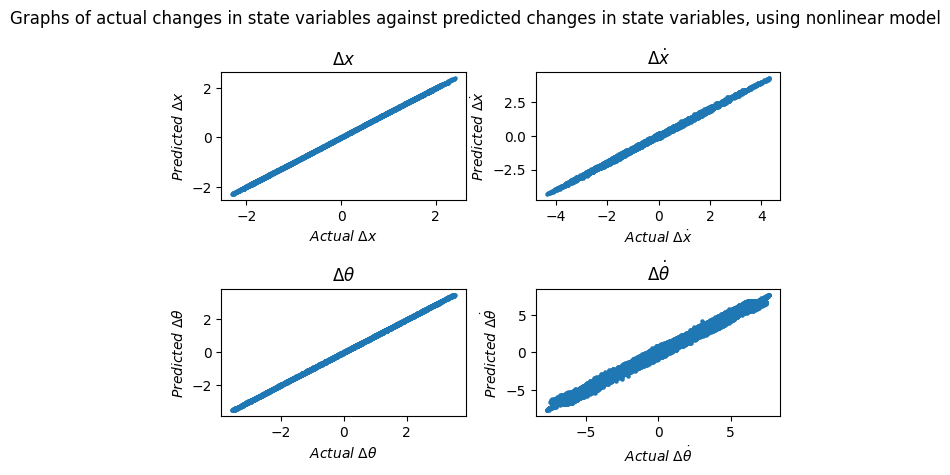

In [7]:
### TASK 2.1: scatter plots of actual against predicted step

## Global variables:
## num_datapoints = 10000;  datapoints


# get datapoints
num_datapoints = 8000 # 400
datapoints = make_array_of_XY_datapoints(num_datapoints)

# set sigma to the std of datapoints # MAYBE WAIT AND SET THIS TO OPTIMAL VALUES FOUND?
sigma = np.array([52.8, 62.7, 0.32, 13.4])
num_basis_centres = 700 # 150
lamda = 10**(-2.5)



## test on real data

# define function to plot scatter plots of actual against predicted step
def make_scatter_plot_actual_against_predicted_step(datapoints, num_basis_centres, sigma, lamda):

    # train model to find the alpha vectors
    K_MN = get_K_MN_matrix(num_basis_centres, num_datapoints, sigma, datapoints) 
    K_NM = K_MN.T
    K_MM = get_K_MM_matrix(num_basis_centres, sigma)
    alpha_x = get_alpha(K_MN, K_MM, lamda, datapoints, index=0)
    alpha_xdot = get_alpha(K_MN, K_MM, lamda, datapoints, index=1)
    alpha_theta = get_alpha(K_MN, K_MM, lamda, datapoints, index=2)
    alpha_thetadot = get_alpha(K_MN, K_MM, lamda, datapoints, index=3)


    # initialise lists into which actual steps to plot will go
    actual_steps_x, actual_steps_xdot, actual_steps_theta, actual_steps_thetadot = [], [], [], []

    # make lists of actual steps
    for i in range(len(datapoints)):

        # current Y vector
        Y = datapoints[i][1]

        # populate lists of actual steps
        actual_steps_x.append(Y[0])
        actual_steps_xdot.append(Y[1])
        actual_steps_theta.append(Y[2])
        actual_steps_thetadot.append(Y[3])
    

    # make lists predicted steps
    pred_steps_x = np.matmul(K_NM, alpha_x)
    pred_steps_xdot = np.matmul(K_NM, alpha_xdot)
    pred_steps_theta = np.matmul(K_NM, alpha_theta)
    pred_steps_thetadot = np.matmul(K_NM, alpha_thetadot)

    plt.subplot(2, 2, 1)
    plt.scatter(actual_steps_x, pred_steps_x, s=5)
    plt.title(r'$\Delta x$')
    plt.xlabel(r'$Actual\ \Delta x$')
    plt.ylabel(r'$Predicted\ \Delta x$')
    
    plt.subplot(2, 2, 2)
    plt.scatter(actual_steps_xdot, pred_steps_xdot, s=5)
    plt.title(r'$\Delta \dot{x}$')
    plt.xlabel(r'$Actual\ \Delta \dot{x}$')
    plt.ylabel(r'$Predicted\ \Delta \dot{x}$')

    plt.subplot(2, 2, 3)
    plt.scatter(actual_steps_theta, pred_steps_theta, s=5)
    plt.title(r'$\Delta \theta$')
    plt.xlabel(r'$Actual\ \Delta \theta$')
    plt.ylabel(r'$Predicted\ \Delta \theta$')

    plt.subplot(2, 2, 4)
    plt.scatter(actual_steps_thetadot, pred_steps_thetadot, s=5)
    plt.title(r'$\Delta \dot{\theta}$')
    plt.xlabel(r'$Actual\ \Delta \dot{\theta}$')
    plt.ylabel(r'$Predicted\ \Delta \dot{\theta}$')

    plt.suptitle('Graphs of actual changes in state variables against predicted changes in state variables, using nonlinear model')
    plt.tight_layout()
    plt.show() 


make_scatter_plot_actual_against_predicted_step(datapoints, num_basis_centres, sigma, lamda)


40 [0.98436941 0.22249298 0.17793405 3.03583189]
80 [0.60276182 0.19198511 0.02742802 0.30696993]
120 [0.10170797 0.19546908 0.02535157 0.26135356]
160 [0.02477597 0.10813013 0.0152593  0.19055948]
200 [0.01510523 0.0752394  0.00345355 0.17504781]
240 [0.00564898 0.05255815 0.00112037 0.15417581]
280 [0.00264373 0.02896146 0.0010553  0.14704572]
320 [0.00142153 0.02116292 0.00110467 0.1546873 ]
360 [0.00080806 0.01458991 0.00098067 0.15394734]
400 [0.00052877 0.01221436 0.00090215 0.15108563]
440 [0.00042246 0.01169366 0.00087776 0.15155834]
480 [0.00035952 0.01221241 0.00082766 0.15402934]
520 [0.00031163 0.01115486 0.0007896  0.153635  ]
560 [0.000291   0.01074498 0.00073436 0.16118715]
600 [0.00025878 0.00982834 0.00070759 0.16309819]
640 [0.00023425 0.0096242  0.00067703 0.16023111]
680 [0.00022357 0.01001605 0.00067986 0.16600658]
720 [0.00021185 0.00955947 0.00067023 0.16750203]
760 [0.00020379 0.00925148 0.00065577 0.16737286]
800 [0.00019098 0.00915633 0.00064075 0.16681718]
84

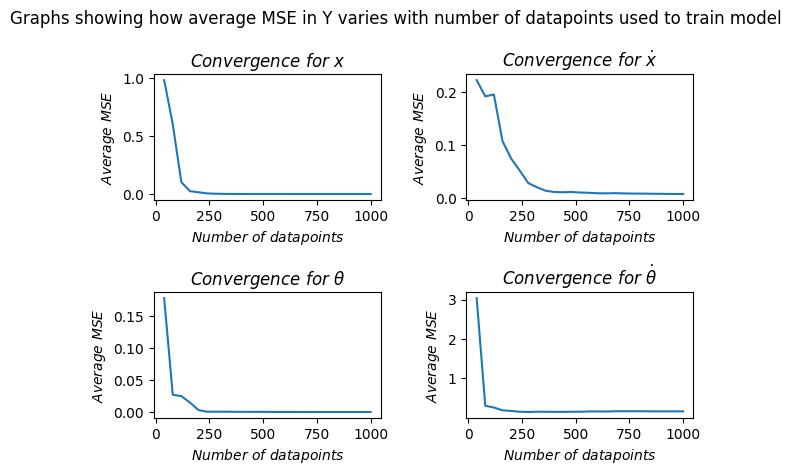

40 [0.98436941 0.22249298 0.17793405 3.03583189]
80 [0.60276182 0.19198511 0.02742802 0.30696993]
120 [0.10170797 0.19546908 0.02535157 0.26135356]
160 [0.02477597 0.10813013 0.0152593  0.19055948]
200 [0.01510523 0.0752394  0.00345355 0.17504781]
240 [0.00564898 0.05255815 0.00112037 0.15417581]
280 [0.00264373 0.02896146 0.0010553  0.14704572]
320 [0.00142153 0.02116292 0.00110467 0.1546873 ]
360 [0.00080806 0.01458991 0.00098067 0.15394734]
400 [0.00052877 0.01221436 0.00090215 0.15108563]
440 [0.00042246 0.01169366 0.00087776 0.15155834]
480 [0.00035952 0.01221241 0.00082766 0.15402934]
520 [0.00031163 0.01115486 0.0007896  0.153635  ]
560 [0.000291   0.01074498 0.00073436 0.16118715]
600 [0.00025878 0.00982834 0.00070759 0.16309819]
640 [0.00023425 0.0096242  0.00067703 0.16023111]
680 [0.00022357 0.01001605 0.00067986 0.16600658]
720 [0.00021185 0.00955947 0.00067023 0.16750203]
760 [0.00020379 0.00925148 0.00065577 0.16737286]
800 [0.00019098 0.00915633 0.00064075 0.16681718]
84

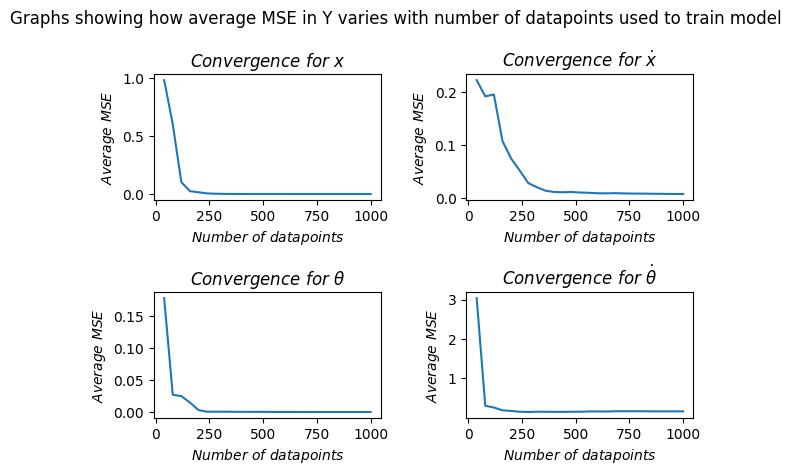

In [38]:
## CONVERGENCE AGAINST NUMBER OF DATAPOINTS    

# function to plot number of datapoints against convergence
def plot_num_datapoints_against_convergence(datapoints, num_basis_centres, sigma, lamda, num_its=0):

    # choose 25 samples of amount of datapoints to test
    no_samples = 25

    no_datapoints = len(datapoints)

    # create list of number of datapoints to test
    nos_datapoints_to_test = [(no_datapoints/no_samples)*i for i in range(1, no_samples+1)]

    # round down to make whole numbers
    nos_datapoints_to_test = [int(datapoint // 1) for datapoint in nos_datapoints_to_test]



    # ####### QUESTION I'VE ASKED RELEVENT HERE:

    # make number of basis centres list such that the ratio of number of basis centres 
    # to datatpoints is approximately constant
    no_basis_centres_to_test = [(num_basis_centres/no_datapoints)*num_datapoints for num_datapoints in nos_datapoints_to_test]

    # round down to make whole numbers
    no_basis_centres_to_test = [int(no_centres // 1) for no_centres in no_basis_centres_to_test]

    # remove any elements with < 5 basis centres
    while no_basis_centres_to_test[0] < 5:
        no_basis_centres_to_test.pop(0)
        nos_datapoints_to_test.pop(0)

    # ###############


    # initilise empty error lists into which systematic errors to plot will go
    errors_x, errors_xdot, errors_theta, errors_thetadot = [], [], [], []

    # for each number of datapoitns to test
    for i, no_datapoints in enumerate(nos_datapoints_to_test):

        # create shortened set of datapoints
        datapoints_to_test = datapoints[:no_datapoints]

        # find and populate errors to plot
        error_vector = get_error_between_actual_and_predicted(datapoints_to_test, no_basis_centres_to_test[i], sigma, lamda) ##### QUESTION I'VE ASKED IS RELEVENT HERE
        #error_vector = get_error_between_actual_and_predicted(datapoints_to_test, num_basis_centres, sigma, lamda, num_its)
        print(no_datapoints, error_vector)
        errors_x.append(error_vector[0])
        errors_xdot.append(error_vector[1])
        errors_theta.append(error_vector[2])
        errors_thetadot.append(error_vector[3])

    plt.subplot(2, 2, 1)
    plt.plot(nos_datapoints_to_test, errors_x)
    plt.title(r'$Convergence\ for\ x$')
    plt.xlabel(r'$Number\ of\ datapoints$')
    plt.ylabel(r'$Average\ MSE$')

    plt.subplot(2, 2, 2)
    plt.plot(nos_datapoints_to_test, errors_xdot)
    plt.title(r'$Convergence\ for\ \dot{x}$')
    plt.xlabel(r'$Number\ of\ datapoints$')
    plt.ylabel(r'$Average\ MSE$')

    plt.subplot(2, 2, 3)
    plt.plot(nos_datapoints_to_test, errors_theta)
    plt.title(r'$Convergence\ for\ \theta$')
    plt.xlabel(r'$Number\ of\ datapoints$')
    plt.ylabel(r'$Average\ MSE$')

    plt.subplot(2, 2, 4)
    plt.plot(nos_datapoints_to_test, errors_thetadot)
    plt.title(r'$Convergence\ for\ \dot{\theta}$')
    plt.xlabel(r'$Number\ of\ datapoints$')
    plt.ylabel(r'$Average\ MSE$')

    plt.suptitle('Graphs showing how average MSE in Y varies with number of datapoints used to train model')
    # plt.suptitle('Graphs showing how average MSE in Y varies with number of datapoints used to train model, keeping number of basis centres constant')
    plt.tight_layout()
    plt.show()




# get datapoints
num_datapoints = 1000 # test wide range of num_datapoints
datapoints = make_array_of_XY_datapoints(num_datapoints)

# set to reasonable values
sigma = np.array([52.8, 62.7, 0.32, 13.4])
num_basis_centres = num_datapoints//3
lamda = 10**(-2.5)


# print(get_error_between_actual_and_predicted(datapoints, num_basis_centres, sigma, lamda, num_its=0))
# print(get_error_between_actual_and_predicted(datapoints[:500], num_basis_centres, sigma, lamda, num_its=0))
# print(get_error_between_actual_and_predicted(datapoints[:100], num_basis_centres, sigma, lamda, num_its=0))

# print(get_error_between_actual_and_predicted(datapoints, num_basis_centres, sigma, lamda, num_its=2))
# print(get_error_between_actual_and_predicted(datapoints[:500], num_basis_centres, sigma, lamda, num_its=2))
# print(get_error_between_actual_and_predicted(datapoints[:100], num_basis_centres, sigma, lamda, num_its=2))



plot_num_datapoints_against_convergence(datapoints, num_basis_centres, sigma, lamda, num_its=0)
plot_num_datapoints_against_convergence(datapoints, num_basis_centres, sigma, lamda, num_its=2)

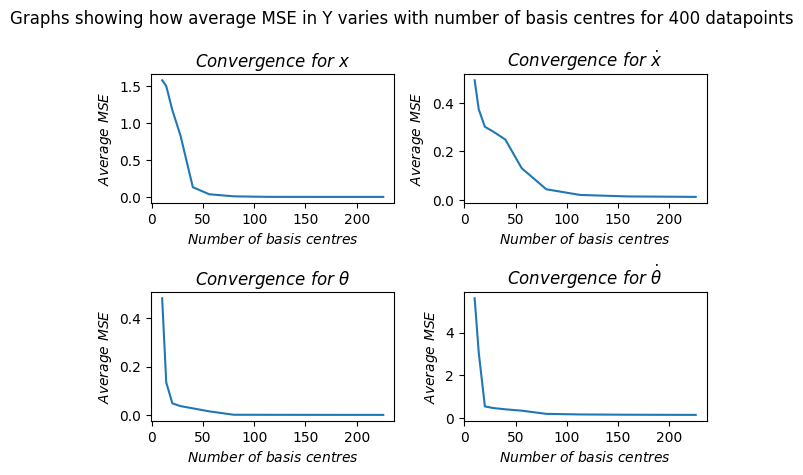

In [47]:
## TASK 2.1, CONVERGENCE AGAINST NUMBER OF BASIS CENTRES

# function to plot graphs showing how convergence varies with number of basis centres
# no need to specify the range of number of basis centres to test, it's done within the function
def plot_num_basis_centres_against_convergence(datapoints, sigma, lamda, num_its=0):

    no_datapoints = len(datapoints)
    
    # initialise empty list into which number of basis centres to plot will go
    num_basis_centres_to_plot = []

    # start with 10
    current_no_basis_centres = 10
    
    # populate list of number of basis centres to plot with doubling numbers until it reaches the number of datapoitns
    while current_no_basis_centres < no_datapoints:
        
        num_basis_centres_to_plot.append(int(current_no_basis_centres//1))
        current_no_basis_centres *= 2**0.5
        if current_no_basis_centres > no_datapoints/1.5:
            break
    
    # now add 2 more plots evenly spaced
    #step_size = (no_datapoints - num_basis_centres_to_plot[-1]) // 3
    #num_basis_centres_to_plot.append(num_basis_centres_to_plot[-1] + step_size)
    #num_basis_centres_to_plot.append(num_basis_centres_to_plot[-1] + step_size)    
    

    # initilise empty error lists into which systematic errors to plot will go
    errors_x, errors_xdot, errors_theta, errors_thetadot = [], [], [], []


    # find average systematic error for different number of basis centres
    for no_basis_centres in num_basis_centres_to_plot:
        
        error_vector = get_error_between_actual_and_predicted(datapoints, no_basis_centres, sigma, lamda, num_its)
        errors_x.append(error_vector[0])
        errors_xdot.append(error_vector[1])
        errors_theta.append(error_vector[2])
        errors_thetadot.append(error_vector[3])
    

    plt.subplot(2, 2, 1)
    plt.plot(num_basis_centres_to_plot, errors_x)
    plt.title(r'$Convergence\ for\ x$')
    plt.xlabel(r'$Number\ of\ basis\ centres$')
    plt.ylabel(r'$Average\ MSE$')

    plt.subplot(2, 2, 2)
    plt.plot(num_basis_centres_to_plot, errors_xdot)
    plt.title(r'$Convergence\ for\ \dot{x}$')
    plt.xlabel(r'$Number\ of\ basis\ centres$')
    plt.ylabel(r'$Average\ MSE$')

    plt.subplot(2, 2, 3)
    plt.plot(num_basis_centres_to_plot, errors_theta)
    plt.title(r'$Convergence\ for\ \theta$')
    plt.xlabel(r'$Number\ of\ basis\ centres$')
    plt.ylabel(r'$Average\ MSE$')

    plt.subplot(2, 2, 4)
    plt.plot(num_basis_centres_to_plot, errors_thetadot)
    plt.title(r'$Convergence\ for\ \dot{\theta}$')
    plt.xlabel(r'$Number\ of\ basis\ centres$')
    plt.ylabel(r'$Average\ MSE$')

    plt.suptitle('Graphs showing how average MSE in Y varies with number of basis centres for {} datapoints'.format(no_datapoints))
    plt.tight_layout()
    plt.show()

        
    
# get datapoints
num_datapoints = 400
datapoints = make_array_of_XY_datapoints(num_datapoints)

# set to reasonable values
sigma = get_std_as_vector(datapoints)
sigma = np.array([52.8, 62.7, 0.32, 13.4]) # optimum
lamda = 10**(-3.5)
lamda = 10**(-2.5) # optimum


plot_num_basis_centres_against_convergence(datapoints, sigma, lamda, num_its=0)
# plot_num_basis_centres_against_convergence(datapoints, sigma, lamda, num_its=2)






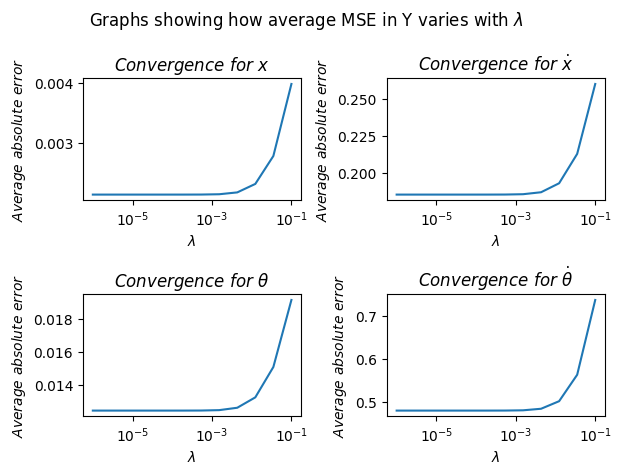

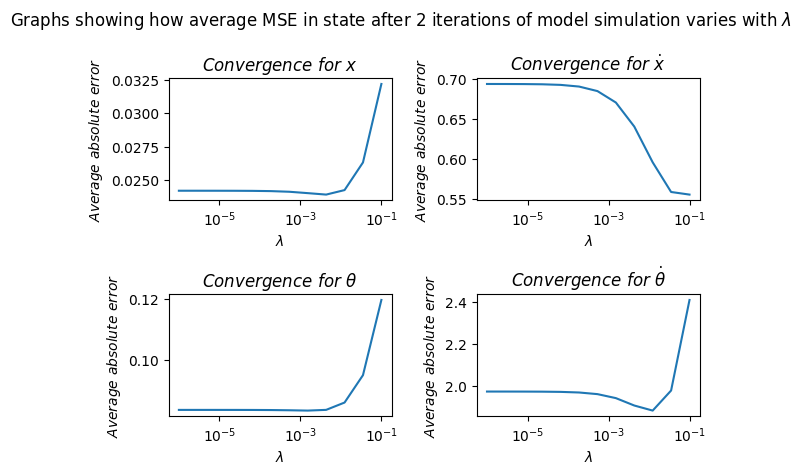

In [12]:
### TASK 2.1, CONVERGENCE AGAINST LAMDA

# function to plot graphs showing how convergence varies with lamda
# no need to specify the range of lamdas to test, it's done within the function
def plot_lamda_against_convergence(datapoints, no_basis_centres, sigma, num_its=0):

    # make logarithmic array of lamdas to test, testing from 10^-6 to 10^-1
    lamdas_to_test = np.logspace(np.log10(10**(-6)), np.log10(10**(-1)), num=12, base=10)

    # initilise empty error lists into which systematic errors to plot will go
    errors_x, errors_xdot, errors_theta, errors_thetadot = [], [], [], []

    # find average systematic error for different number of basis centres
    for lamda in lamdas_to_test:
        error_vector = get_error_between_actual_and_predicted(datapoints, no_basis_centres, sigma, lamda, num_its)
        errors_x.append(error_vector[0])
        errors_xdot.append(error_vector[1])
        errors_theta.append(error_vector[2])
        errors_thetadot.append(error_vector[3])
    
    # plot graphs
    plt.subplot(2, 2, 1)
    plt.plot(lamdas_to_test, errors_x)
    plt.xscale('log')
    plt.title(r'$Convergence\ for\ x$')
    plt.xlabel(r'$\lambda$')
    plt.ylabel(r'$Average\ absolute\ error$')

    plt.subplot(2, 2, 2)
    plt.plot(lamdas_to_test, errors_xdot)
    plt.xscale('log')
    plt.title(r'$Convergence\ for\ \dot{x}$')
    plt.xlabel(r'$\lambda$')
    plt.ylabel(r'$Average\ absolute\ error$')

    plt.subplot(2, 2, 3)
    plt.plot(lamdas_to_test, errors_theta)
    plt.xscale('log')
    plt.title(r'$Convergence\ for\ \theta$')
    plt.xlabel(r'$\lambda$')
    plt.ylabel(r'$Average\ absolute\ error$')

    plt.subplot(2, 2, 4)
    plt.plot(lamdas_to_test, errors_thetadot)
    plt.xscale('log')
    plt.title(r'$Convergence\ for\ \dot{\theta}$')
    plt.xlabel(r'$\lambda$')
    plt.ylabel(r'$Average\ absolute\ error$')

    if num_its == 0:
        plt.suptitle('Graphs showing how average MSE in Y varies with $\lambda$')
    else:
        plt.suptitle('Graphs showing how average MSE in state after {} iterations of model simulation varies with $\lambda$'.format(num_its))
    plt.tight_layout()
    plt.show()



# get datapoints
num_datapoints = 500
datapoints = make_array_of_XY_datapoints(num_datapoints)

# set to reasonable values
sigma = get_std_as_vector(datapoints)
no_basis_centres = 150


#plot_lamda_against_convergence(datapoints, no_basis_centres, sigma, num_its=0)
#plot_lamda_against_convergence(datapoints, no_basis_centres, sigma, num_its=2) # took about 2 mins to run with 2 iterations
    

### from looking at graphs generated above, we want to pick the largest value of lamda that gives a good convergence
### this value of lamda is about 10^-2.5

    

104.49256070312198 116.70773763285881 0.45598351602897186 11.767594386896677


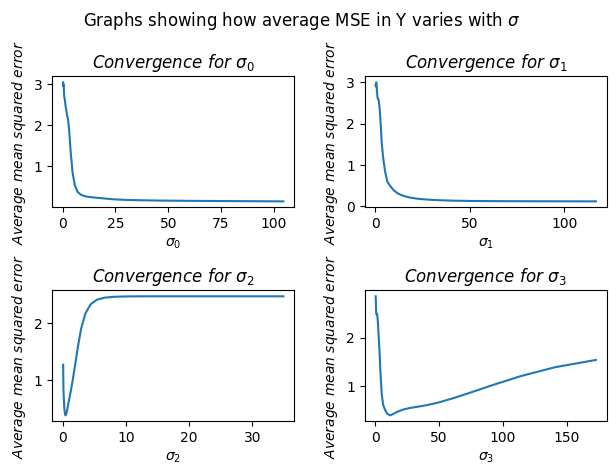

KeyboardInterrupt: 

In [153]:
### CONVERGENCE AGAINST SIGMA

# function to plot convergence against sigma, where 'convergence' is average mse between actual and predicted values looking after 1 iteration (comparing Y and X)
# proportion_of_sigma_to_test is a fraction. eg if = 1/3, it means we test sigmas from 1/3 to 3 of the std
def plot_sigma_against_convergence(datapoints, num_basis_centres, lamda, proportion_of_sigma_to_test, const_sigma_values, no_increments, num_its=0):

    # create list of sigmas to test, starting with std of datapoitns USING LINEAR SCALE
    start_sigma = get_std_as_vector(datapoints)
    # sigma_0_to_test = np.linspace(start_sigma[0]*proportion_of_sigma_to_test, start_sigma[0]/proportion_of_sigma_to_test, no_increments)
    # sigma_1_to_test = np.linspace(start_sigma[1]*proportion_of_sigma_to_test, start_sigma[1]/proportion_of_sigma_to_test, no_increments)
    # sigma_2_to_test = np.linspace(start_sigma[2]*proportion_of_sigma_to_test, start_sigma[2]/proportion_of_sigma_to_test, no_increments)
    # sigma_3_to_test = np.linspace(start_sigma[3]*proportion_of_sigma_to_test, start_sigma[3]/proportion_of_sigma_to_test, no_increments)

    # create lists of sigmas to test, starting with std of datapoints USING LOG SCALE
    sigma_0_to_test = np.logspace(np.log10(start_sigma[0]*proportion_of_sigma_to_test), np.log10(start_sigma[0]/proportion_of_sigma_to_test), no_increments)
    sigma_1_to_test = np.logspace(np.log10(start_sigma[1]*proportion_of_sigma_to_test), np.log10(start_sigma[1]/proportion_of_sigma_to_test), no_increments)
    sigma_2_to_test = np.logspace(np.log10(start_sigma[2]*proportion_of_sigma_to_test), np.log10(start_sigma[2]/proportion_of_sigma_to_test), no_increments)
    sigma_3_to_test = np.logspace(np.log10(start_sigma[3]*proportion_of_sigma_to_test), np.log10(start_sigma[3]/proportion_of_sigma_to_test), no_increments)

    # create empty lists into which average errors over all state variables will go
    ave_errors_for_sigma0 = []
    ave_errors_for_sigma1 = []
    ave_errors_for_sigma2 = []
    ave_errors_for_sigma3 = []

    # testing all values of sigma0
    for sigma0 in sigma_0_to_test:

        sigma = [sigma0, const_sigma_values, const_sigma_values, const_sigma_values]

        # get and append average error over all state variables
        error_vector = get_error_between_actual_and_predicted(datapoints, num_basis_centres, sigma, lamda, num_its)
        ave_error = np.average(error_vector)
        ave_errors_for_sigma0.append(ave_error)
    
    # testing all values of sigma1
    for sigma1 in sigma_1_to_test:

        sigma = [const_sigma_values, sigma1, const_sigma_values, const_sigma_values]

        # get and append average error over all state variables
        error_vector = get_error_between_actual_and_predicted(datapoints, num_basis_centres, sigma, lamda, num_its)
        ave_error = np.average(error_vector)
        ave_errors_for_sigma1.append(ave_error)
    
    # testing all values of sigma2
    for sigma2 in sigma_2_to_test:

        sigma = [const_sigma_values, const_sigma_values, sigma2, const_sigma_values]

        # get and append average error over all state variables
        error_vector = get_error_between_actual_and_predicted(datapoints, num_basis_centres, sigma, lamda, num_its)
        ave_error = np.average(error_vector)
        ave_errors_for_sigma2.append(ave_error)
    
    # testing all values of sigma3
    for sigma3 in sigma_3_to_test:

        sigma = [const_sigma_values, const_sigma_values, const_sigma_values, sigma3]

        # get and append average error over all state variables
        error_vector = get_error_between_actual_and_predicted(datapoints, num_basis_centres, sigma, lamda, num_its)
        ave_error = np.average(error_vector)
        ave_errors_for_sigma3.append(ave_error)
    
    min_index_0 = np.argmin(ave_errors_for_sigma0)
    min_index_1 = np.argmin(ave_errors_for_sigma1)
    min_index_2 = np.argmin(ave_errors_for_sigma2)
    min_index_3 = np.argmin(ave_errors_for_sigma3)
    print(sigma_0_to_test[min_index_0], sigma_1_to_test[min_index_1], sigma_2_to_test[min_index_2], sigma_3_to_test[min_index_3])
    
    # plot graphs

    plt.subplot(2, 2, 1)
    plt.plot(sigma_0_to_test, ave_errors_for_sigma0)
    plt.title(r'$Convergence\ for\ \sigma_0$')
    plt.xlabel(r'$\sigma_0$')
    plt.ylabel(r'$Average\ mean\ squared\ error$')

    plt.subplot(2, 2, 2)
    plt.plot(sigma_1_to_test, ave_errors_for_sigma1)
    plt.title(r'$Convergence\ for\ \sigma_1$')
    plt.xlabel(r'$\sigma_1$')
    plt.ylabel(r'$Average\ mean\ squared\ error$')

    plt.subplot(2, 2, 3)
    plt.plot(sigma_2_to_test, ave_errors_for_sigma2)
    plt.title(r'$Convergence\ for\ \sigma_2$')
    plt.xlabel(r'$\sigma_2$')
    plt.ylabel(r'$Average\ mean\ squared\ error$')

    plt.subplot(2, 2, 4)
    plt.plot(sigma_3_to_test, ave_errors_for_sigma3)
    plt.title(r'$Convergence\ for\ \sigma_3$')
    plt.xlabel(r'$\sigma_3$')
    plt.ylabel(r'$Average\ mean\ squared\ error$')

    if num_its == 0:
        plt.suptitle('Graphs showing how average MSE in Y varies with $\sigma$')
    
    else:
        plt.suptitle('Graphs showing how average MSE in state after ' + str(num_its) + ' iterations of model simulation varies with $\sigma$')
    plt.tight_layout()
    plt.show()

    



    
# print(get_std_as_vector(datapoints)) # around 5, 5.7, 1.8, 8.6


# get datapoints
num_datapoints = 400
datapoints = make_array_of_XY_datapoints(num_datapoints)

# set to reasonable values
sigma = get_std_as_vector(datapoints)
num_basis_centres = 200

proportion_of_sigma_to_test = 1/20
const_sigma_values = 3 # approx. average value of the std values
no_increments = 30

lamda = 10**(-3)

plot_sigma_against_convergence(datapoints, num_basis_centres, lamda, proportion_of_sigma_to_test, const_sigma_values, no_increments, num_its=0)
plot_sigma_against_convergence(datapoints, num_basis_centres, lamda, proportion_of_sigma_to_test, const_sigma_values, no_increments, num_its=2)

    

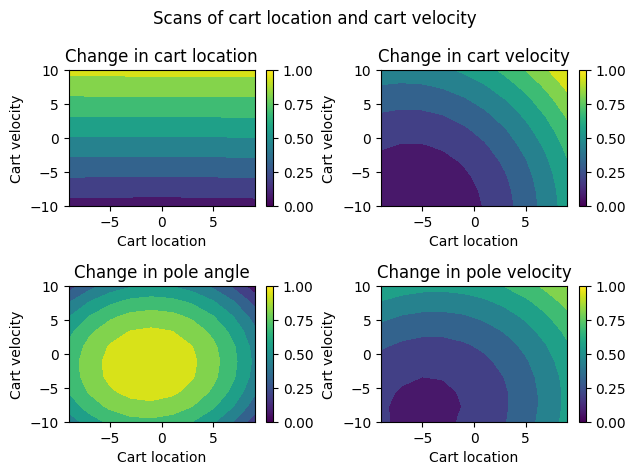

z length: 100
[-2.025236569850835, -2.03821076789578, -2.0479247999157364, -2.054329614515131, -2.057391934760446, -2.0570945373547422, -2.0534364049469236, -2.0464327497623462, -2.036114908153088, -2.022530107092707, -1.5925624574913388, -1.602678058443041, -1.6101377682503235, -1.6149020892135595, -1.6169447178812022, -1.6162527748436997, -1.612826926219351, -1.6066813953179144, -1.5978438642035988, -1.5863552661114564, -1.1542205193567752, -1.1614325520411373, -1.1666013501550305, -1.1696971345571863, -1.1707007021523381, -1.1696036053551526, -1.1664082420860666, -1.1611278551043365, -1.1537864405190128, -1.1444185663641049, -0.7118382166001657, -0.7161123955342877, -0.7189621025097273, -0.7203674061242845, -0.7203163045614549, -0.7188048539527749, -0.7158372263369521, -0.7114256963374327, -0.7055905565304372, -0.6983599623151899, -0.26706784033772624, -0.268380788195035, -0.2688918209530037, -0.26859094762200053, -0.2674734419688265, -0.26553991919567477, -0.2627963614309093, -0.25

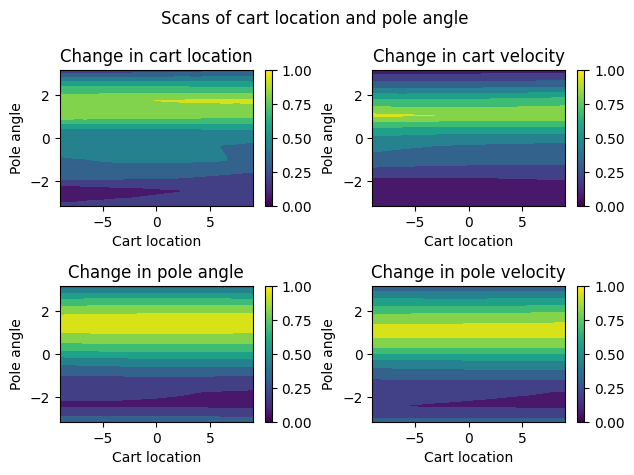

z length: 100
[0.15615786377395807, 0.1576696633778837, 0.15939055994086873, 0.16132104901377323, 0.16345890089651105, 0.1657991334196236, 0.16833401758908975, 0.17105311633863646, 0.17394335616626683, 0.17698913096552385, 0.1254825330915235, 0.12957900863987867, 0.1336831325974196, 0.13777612721654992, 0.14183843552563774, 0.14584987482002928, 0.1497898003440195, 0.15363727733871604, 0.15737125948510347, 0.1609707716720506, 0.19712144729994502, 0.1958567963304495, 0.1942018901284583, 0.19215836872403663, 0.18972993108467223, 0.18692234423027332, 0.1837434349825358, 0.18020306410144438, 0.1763130827692997, 0.17208727158735926, 0.204379071855727, 0.2079717103834553, 0.21073836789322842, 0.2126619118099975, 0.21373112115501014, 0.21394078781582637, 0.21329175815185097, 0.2117909144761354, 0.20945109672376194, 0.20629096537944758, 0.22563764943229714, 0.2255820123682497, 0.22486995016806333, 0.22350700174763993, 0.22150297255903695, 0.21887183664506438, 0.2156315984828634, 0.2118041163793

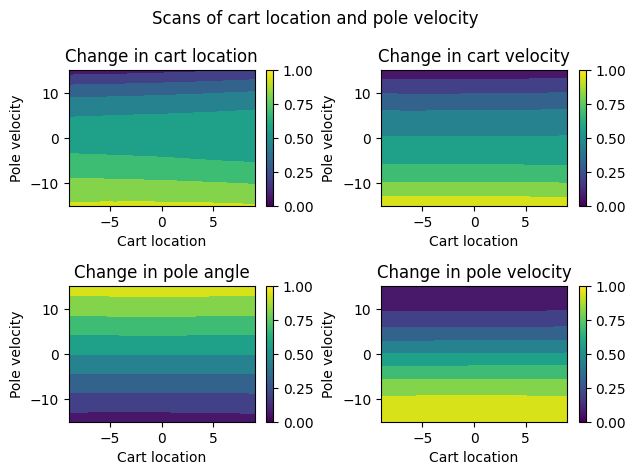

z length: 100
[0.40790220630535634, 0.41007348205235966, 0.4116244467241798, 0.4125514614074269, 0.41285376312433464, 0.4125334476337935, 0.4115954303069859, 0.41004738570733124, 0.4078996667333324, 0.40516520439210196, 0.3661695316694155, 0.3660770066380694, 0.36545103978690224, 0.3642983054583419, 0.36262781194541993, 0.36045080842334387, 0.35778067547857684, 0.35463280062357583, 0.3510244403281836, 0.34697457022775957, 0.3100393232640749, 0.30850398262386175, 0.3065717572402755, 0.3042559710232498, 0.30157142027124106, 0.2985342335305847, 0.29516172346488334, 0.29147223254398297, 0.2874849744002111, 0.2832198727155902, 0.2574987004743516, 0.25564062834550094, 0.25354477031386957, 0.25122617095232047, 0.2487002950154137, 0.2459828778004853, 0.24308977775165716, 0.24003683313444085, 0.23683972451012225, 0.23351384463037075, 0.21896835385589708, 0.21781641768794857, 0.2165844590139192, 0.21528469538172462, 0.2139286603393133, 0.21252707868807147, 0.21108975480894096, 0.2096254755285942

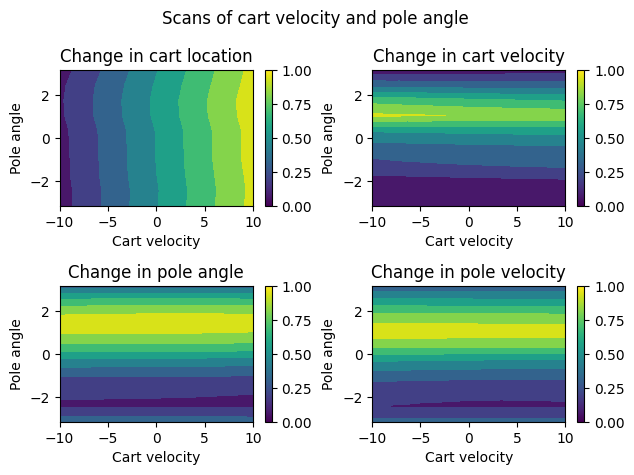

z length: 100
[-2.0576636450828745, -1.616940844341338, -1.1704148415606197, -0.7197430525448126, -0.26660843457195316, 0.18729098382252565, 0.6402527035205884, 1.090580393343437, 1.5365944733887609, 1.9766425507854108, -2.06311860540847, -1.6250256723139074, -1.181372178230733, -0.7338067801412986, -0.2840018771329847, 0.1663568006386828, 0.6155807169413782, 1.0619890764443325, 1.5039193014987307, 1.9397373473309016, -2.0194589573481787, -1.580233043554171, -1.1359318365227706, -0.6882059477118474, -0.23872625255650443, 0.2108264978947238, 0.6587721473342463, 1.1034415952605805, 1.5431871576111296, 1.9763927369641756, -2.0166204523345597, -1.573334591602884, -1.1246922926173673, -0.6723549695090498, -0.2180063461092283, 0.2366579849280135, 0.6899411037878673, 1.1401553142293177, 1.58563261159144, 2.0247349772177197, -1.9988776840766267, -1.5590878101743026, -1.113351118972707, -0.6633151265347994, -0.2106542683332311, 0.2429404792467018, 0.6957721223646036, 1.1461482264980347, 1.59239

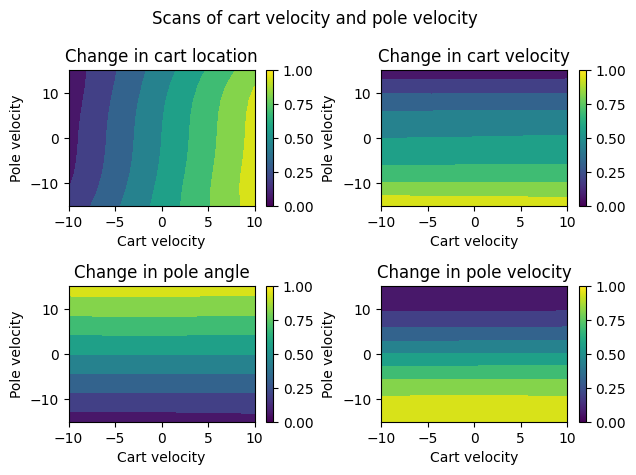

z length: 100
[-1.6357598227434293, -1.2280840586540744, -0.8157657218219808, -0.400341059107953, 0.016634224364493418, 0.43359467099593935, 0.8489748620261485, 1.261219208676848, 1.6687916574210524, 2.0701852246452637, -1.8014290420925878, -1.3712044029307764, -0.9359580014891319, -0.49731106302464523, -0.056905908501447056, 0.38360428942972796, 0.8225658448330451, 1.25833490079492, 1.6892876851174816, 2.1138305898621113, -1.9109477671027155, -1.4714446455659178, -1.0266719050447513, -0.5782854716652955, -0.12796353301342023, 0.32260392589673464, 0.7717256886747105, 1.2177198831766414, 1.658924474152258, 2.093707581313359, -1.9705134821511903, -1.5299307939472833, -1.08392218569363, -0.6341470619192711, -0.1822879570410928, 0.26995995049036003, 0.72089943313311, 1.1688418256122945, 1.612117559857247, 2.0490865315373563, -1.999297328448715, -1.560039949777738, -1.1152379977925286, -0.6665450302588323, -0.21563851157794778, 0.23579063511101384, 0.6860485920280326, 1.1334492346853475, 1.

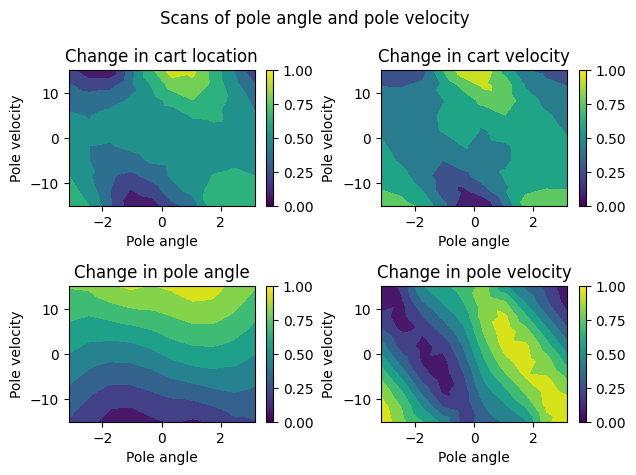

z length: 100
[0.41277119079805524, 0.2973960825721216, 0.02562159104510449, -0.24271500510533772, -0.22924967885149927, -0.040910332143017314, 0.05632327717696883, 0.39760571805246814, 0.44411400701233306, 0.41277119079799796, 0.36160183621479636, 0.22981558634682883, 0.0006640280461239212, -0.16075614949535533, -0.08900054906045263, 0.09594609830606693, 0.1954734398740614, 0.37830659280922574, 0.3972821550596482, 0.36160183621486025, 0.300095850328152, 0.17741156704080902, 0.015392759035506964, -0.039062998217965106, 0.057170131733731644, 0.17174838655899727, 0.23021592296970894, 0.30644397192551454, 0.32804645054973286, 0.3000958503281004, 0.2473645390974325, 0.15231969448085836, 0.06870446101141658, 0.08943558245442174, 0.16977303651630216, 0.18844921608632248, 0.2051823583744028, 0.23959320495690895, 0.272444793804133, 0.24736453909740394, 0.21323292728117116, 0.15271003559730062, 0.13929816744719564, 0.18694519545391475, 0.2256840798113764, 0.1756636787877106, 0.18562995984255082

In [6]:
### TASK 2.1, 2D SLICES OF TARGET FUNCTION

# function to plot 2D scans of state variables using non-linear model
def plot_2D_scans_nonlinear_model(num_basis_centres, alpha_x, alpha_xdot, alpha_theta, alpha_thetadot, sigma, constant_state, no_increments=20):

    # initialise lists corresponding to state variables to scan over: cart.loc = 9, cart.vel = 10, pole.angle = pi, pole.vel = 15
    list_of_ranges = [[9, 10], [9, np.pi], [9, 15], [10, np.pi], [10, 15], [np.pi, 15]]

    # create lists of x and y labels and suptitles
    x_labels = ["Cart location", "Cart location", "Cart location", "Cart velocity", "Cart velocity", "Pole angle"]
    y_labels = ["Cart velocity", "Pole angle", "Pole velocity", "Pole angle", "Pole velocity", "Pole velocity"]
    suptitles = ["Scans of cart location and cart velocity", "Scans of cart location and pole angle", "Scans of cart location and pole velocity", "Scans of cart velocity and pole angle", "Scans of cart velocity and pole velocity", "Scans of pole angle and pole velocity"]

    # initialise constant state variables
    constant_cart_location = constant_state[0]
    constant_cart_velocity = constant_state[1]
    constant_pole_angle = constant_state[2]
    constant_pole_velocity = constant_state[3]

    # looking over 10 different combinations of state variables
    for index_of_state_variables_we_scan_over in range(0, 6):

        # get array of values to test in our scan
        x = list_of_ranges[index_of_state_variables_we_scan_over][0]
        y = list_of_ranges[index_of_state_variables_we_scan_over][1]
        array_of_values_of_variable_to_scan_x = np.linspace(-x, x, no_increments)
        array_of_values_of_variable_to_scan_y = np.linspace(-y, y, no_increments)

        # initialise state vector
        state = [constant_cart_location, constant_cart_velocity, constant_pole_angle, constant_pole_velocity]

        # initialise empty lists into which predicted Y values will go
        pred_Y_cart_locations_to_plot = []
        pred_Y_cart_velocities_to_plot = []
        pred_Y_pole_angles_to_plot = []
        pred_Y_pole_velocities_to_plot = []

        # get triangulation
        array_of_values_of_variable_to_scan_x, array_of_values_of_variable_to_scan_y = np.meshgrid(array_of_values_of_variable_to_scan_x, array_of_values_of_variable_to_scan_y)
        array_of_values_of_variable_to_scan_x = array_of_values_of_variable_to_scan_x.flatten()
        array_of_values_of_variable_to_scan_y = array_of_values_of_variable_to_scan_y.flatten()
        triangulation = tri.Triangulation(array_of_values_of_variable_to_scan_x, array_of_values_of_variable_to_scan_y)

        # loop over values the variable which is being scanned takes
        # for i in range(0, no_increments): GOT RID OF THIS BC TRYING A THING OUT
        for i, (xi, yi) in enumerate(zip(array_of_values_of_variable_to_scan_x, array_of_values_of_variable_to_scan_y)):

            # update state vector
            if index_of_state_variables_we_scan_over == 0: # scanning over cart location and cart velocity
                state[0] = array_of_values_of_variable_to_scan_x[i]
                state[1] = array_of_values_of_variable_to_scan_y[i]
            
            elif index_of_state_variables_we_scan_over == 1: # scanning over cart location and pole angle
                state[0] = array_of_values_of_variable_to_scan_x[i]
                state[2] = array_of_values_of_variable_to_scan_y[i]
            
            elif index_of_state_variables_we_scan_over == 2: # scanning over cart location and pole velocity
                state[0] = array_of_values_of_variable_to_scan_x[i]
                state[3] = array_of_values_of_variable_to_scan_y[i]
            
            elif index_of_state_variables_we_scan_over == 3: # scanning over cart velocity and pole angle
                state[1] = array_of_values_of_variable_to_scan_x[i]
                state[2] = array_of_values_of_variable_to_scan_y[i]
            
            elif index_of_state_variables_we_scan_over == 4: # scanning over cart velocity and pole velocity
                state[1] = array_of_values_of_variable_to_scan_x[i]
                state[3] = array_of_values_of_variable_to_scan_y[i]
            
            elif index_of_state_variables_we_scan_over == 5: # scanning over pole angle and pole velocity
                state[2] = array_of_values_of_variable_to_scan_x[i]
                state[3] = array_of_values_of_variable_to_scan_y[i]
            
            else:
                print("error")
            
            
            # get predicted Y accoring to the linear model
            pred_Y = find_Y_given_X_according_to_nonlinear_model(state, num_basis_centres, alpha_x, alpha_xdot, alpha_theta, alpha_thetadot, sigma)

            # append predicted Y values to lists
            pred_Y_cart_locations_to_plot.append(pred_Y[0])
            pred_Y_cart_velocities_to_plot.append(pred_Y[1])
            pred_Y_pole_angles_to_plot.append(pred_Y[2])
            pred_Y_pole_velocities_to_plot.append(pred_Y[3])


        ## Plot the filled contour

        # Create subplots
        fig, axs = plt.subplots(2, 2)

        # plot cart locations
        axs[0, 0].tricontourf(triangulation, pred_Y_cart_locations_to_plot)
        axs[0, 0].set_xlabel(x_labels[index_of_state_variables_we_scan_over])
        axs[0, 0].set_ylabel(y_labels[index_of_state_variables_we_scan_over])
        axs[0, 0].set_title('Change in cart location')
        fig.colorbar(axs[0, 0].collections[0], ax=axs[0, 0])

        # plot cart velocities
        axs[0, 1].tricontourf(triangulation, pred_Y_cart_velocities_to_plot)
        axs[0, 1].set_xlabel(x_labels[index_of_state_variables_we_scan_over])
        axs[0, 1].set_ylabel(y_labels[index_of_state_variables_we_scan_over])
        axs[0, 1].set_title('Change in cart velocity')
        fig.colorbar(axs[0, 1].collections[0], ax=axs[0, 1])

        # plot pole angles
        axs[1, 0].tricontourf(triangulation, pred_Y_pole_angles_to_plot)
        axs[1, 0].set_xlabel(x_labels[index_of_state_variables_we_scan_over])
        axs[1, 0].set_ylabel(y_labels[index_of_state_variables_we_scan_over])
        axs[1, 0].set_title('Change in pole angle')
        fig.colorbar(axs[1, 0].collections[0], ax=axs[1, 0])

        # plot pole velocities
        axs[1, 1].tricontourf(triangulation, pred_Y_pole_velocities_to_plot)
        axs[1, 1].set_xlabel(x_labels[index_of_state_variables_we_scan_over])
        axs[1, 1].set_ylabel(y_labels[index_of_state_variables_we_scan_over])
        axs[1, 1].set_title('Change in pole velocity')
        fig.colorbar(axs[1, 1].collections[0], ax=axs[1, 1])

        fig.suptitle(suptitles[index_of_state_variables_we_scan_over])
        fig.tight_layout()
        plt.show()
        print("z length:", len(pred_Y_cart_locations_to_plot))
        print(pred_Y_cart_locations_to_plot)


# get data 
datapoints = make_array_of_XY_datapoints(400)

# set model parameters, might need to change these
sigma = np.array([52.8, 62.7, 0.32, 13.4])
lamda = 10**(-2.5)                                                                      
num_basis_centres = 220 # len(array_of_X_Y_datapoints_with_action)//3
constant_state = [0, 1, np.pi, 5] # oscillations
num_datapoints = 400

# train model to find the alpha vectors. all these alphas correspond to the same basis vectors: use sobol sequence to get them
K_MN = get_K_MN_matrix(num_basis_centres, num_datapoints, sigma, datapoints) 
K_NM = K_MN.T
K_MM = get_K_MM_matrix(num_basis_centres, sigma)
alpha_x = get_alpha(K_MN, K_MM, lamda, datapoints, index=0) # 
alpha_xdot = get_alpha(K_MN, K_MM, lamda, datapoints, index=1)
alpha_theta = get_alpha(K_MN, K_MM, lamda, datapoints, index=2)
alpha_thetadot = get_alpha(K_MN, K_MM, lamda, datapoints, index=3)

alpha_x, alpha_xdot, alpha_theta, alpha_thetadot = get_optimum_alpha_vectors(datapoints, num_basis_centres, sigma, lamda)

plot_2D_scans_nonlinear_model(num_basis_centres, alpha_x, alpha_xdot, alpha_theta, alpha_thetadot, sigma, constant_state, no_increments=10)


[ 0.          0.02046257  0.02526093 -0.0185607  -0.03632562 -0.01657368
  0.07697419  0.09225624 -0.02617781 -0.11196943 -0.06873609  0.12516483
  0.17804722 -0.02037166 -0.19614576 -0.12747707  0.17710147  0.26653369
 -0.02291376 -0.2856353  -0.17062327  0.23799542  0.34103633 -0.04555796
 -0.36860878 -0.18483977  0.30350741  0.38710567 -0.08918182 -0.43204337
 -0.16751961  0.36572603  0.39970219 -0.14714441 -0.47016414 -0.12413951
  0.41834009  0.38230518 -0.2106974  -0.48358729 -0.06296961]


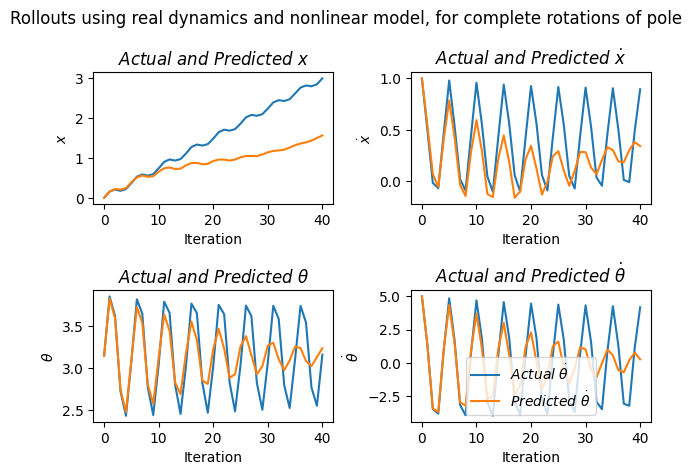

In [68]:
# TASK 2.1, ROLLOUTS

  

# function to plotreturn a list of iterations and a list of actual states (-list of lists)
def plot_actual_and_predicted_rollouts_nonlinear_model(initial_state, num_its, alpha_x, alpha_xdot, alpha_theta, alpha_thetadot, num_basis_centres, sigma):
    
    # create instance of Cartpole with initial_state
    pendulum = CartPole()
    pendulum.setState(initial_state)
    
    # create list of steps
    list_of_its = list(range(num_its+1))

    # start list of states
    list_of_actual_states = [initial_state]
    list_of_predicted_states = [initial_state]

    # iterate to complete simulation
    for step in range(num_its):

        # update state
        pendulum.performAction()

        # append actual next state
        list_of_actual_states.append(pendulum.getState())

        # get predicted next state
        pred_next_state = get_next_state(list_of_predicted_states[-1], alpha_x, alpha_xdot, alpha_theta, alpha_thetadot, num_basis_centres, sigma)

        # append predicted next state
        list_of_predicted_states.append(pred_next_state)
    
    # separate list of states into lists of x, xdot, theta, thetadot
    list_of_actual_x_states = [state[0] for state in list_of_actual_states]
    list_of_actual_xdot_states = [state[1] for state in list_of_actual_states]
    list_of_actual_theta_states = [state[2] for state in list_of_actual_states]
    list_of_actual_thetadot_states = [state[3] for state in list_of_actual_states]

    list_of_predicted_x_states = [state[0] for state in list_of_predicted_states]
    list_of_predicted_xdot_states = [state[1] for state in list_of_predicted_states]
    list_of_predicted_theta_states = [state[2] for state in list_of_predicted_states]
    list_of_predicted_thetadot_states = [state[3] for state in list_of_predicted_states]

    # convert all into np arrays
    list_of_its = np.array(list_of_its)
    list_of_actual_x_states = np.array(list_of_actual_x_states)
    list_of_actual_xdot_states = np.array(list_of_actual_xdot_states)
    list_of_actual_theta_states = np.array(list_of_actual_theta_states)
    list_of_actual_thetadot_states = np.array(list_of_actual_thetadot_states)

    list_of_predicted_x_states = np.array(list_of_predicted_x_states)
    list_of_predicted_xdot_states = np.array(list_of_predicted_xdot_states)
    list_of_predicted_theta_states = np.array(list_of_predicted_theta_states)
    list_of_predicted_thetadot_states = np.array(list_of_predicted_thetadot_states)

    # get difference between actual and predicted states
    list_of_x_state_differences = list_of_actual_x_states - list_of_predicted_x_states
    list_of_xdot_state_differences = list_of_actual_xdot_states - list_of_predicted_xdot_states
    list_of_theta_state_differences = list_of_actual_theta_states - list_of_predicted_theta_states
    list_of_thetadot_state_differences = list_of_actual_thetadot_states - list_of_predicted_thetadot_states

    error_fraction_for_theta = (list_of_theta_state_differences) / 1.2
    print(error_fraction_for_theta)

    
    

    # plot actual and predicted components of state
    plt.subplot(2, 2, 1)
    plt.plot(list_of_its, list_of_actual_x_states, label='Actual x') # list of actual states is a list of lists
    plt.plot(list_of_its, list_of_predicted_x_states, label='Predicted x') # list of predicted states is a list of lists
    plt.xlabel('Iteration')
    plt.ylabel(r'$x$')
    plt.title(r'$Actual\ and\ Predicted\ x$')

    plt.subplot(2, 2, 2)
    plt.plot(list_of_its, list_of_actual_xdot_states, label='Actual xdot') # list of actual states is a list of lists
    plt.plot(list_of_its, list_of_predicted_xdot_states, label='Predicted xdot') # list of predicted states is a list of lists
    plt.xlabel('Iteration')
    plt.ylabel(r'$\dot{x}$')
    plt.title(r'$Actual\ and\ Predicted\ \dot{x}$')

    plt.subplot(2, 2, 3)
    plt.plot(list_of_its, list_of_actual_theta_states, label=r'$Actual\ \theta') # list of actual states is a list of lists
    plt.plot(list_of_its, list_of_predicted_theta_states, label=r'$Predicted\ \theta$') # list of predicted states is a list of lists
    plt.xlabel('Iteration')
    plt.ylabel(r'$\theta$')
    plt.title(r'$Actual\ and\ Predicted\ \theta$')

    plt.subplot(2, 2, 4)
    plt.plot(list_of_its, list_of_actual_thetadot_states, label=r'$Actual\ \dot{\theta}$') # list of actual states is a list of lists
    plt.plot(list_of_its, list_of_predicted_thetadot_states, label=r'$Predicted\ \dot{\theta}$') # list of predicted states is a list of lists
    plt.xlabel('Iteration')
    plt.ylabel(r'$\dot{\theta}$')
    plt.title(r'$Actual\ and\ Predicted\ \dot{\theta}$')
    
    # plt.suptitle('Rollouts using real dynamics and nonlinear model, for pole oscillations about stable equilibrium')
    plt.suptitle('Rollouts using real dynamics and nonlinear model, for complete rotations of pole')
    plt.legend()
    plt.tight_layout()
    plt.show()


# optimal hyperparameters
sigma = np.array([52.8, 62.7, 0.32, 13.4])
num_basis_centres = 150
lamda = 10**(-2.5)
datapoints = make_array_of_XY_datapoints(num_datapoints=400)

alpha_x, alpha_xdot, alpha_theta, alpha_thetadot = get_optimum_alpha_vectors(datapoints, num_basis_centres, sigma, lamda)

initial_state = [0, 1, np.pi, 5] # oscillations
# initial_state = [5, -1, 0, 10] # rotations
num_its = 40

### do this for a 'wide range of initial conditions'
plot_actual_and_predicted_rollouts_nonlinear_model(initial_state, num_its, alpha_x, alpha_xdot, alpha_theta, alpha_thetadot, num_basis_centres, sigma)



In [126]:
### TASK 2.2, FIRST DO 2D SCANS WITH ACTION USING ACTUAL SIMULATION. THESE CAN THEN BE COMPARED TO THE LINEAR AND NONLINEAR MODELS
        
def plot_2D_scans_according_to_simulation_with_action(constant_state, no_increments=20):

    # initialise pendulum
    pendulum = CartPole()

    # initialise lists corresponding to state variables to scan over: cart.loc = 9, cart.vel = 10, pole.angle = pi, pole.vel = 15, action = 4
    list_of_ranges = [[9, 10], [9, np.pi], [9, 15], [9, 4], [10, np.pi], [10, 15], [10, 4], [np.pi, 15], [np.pi, 4], [15, 4]]

    # create lists of x and y labels and suptitles
    x_labels = ["Cart location", "Cart location", "Cart location", "Cart location", "Cart velocity", "Cart velocity", "Cart velocity", "Pole angle", "Pole angle", "Pole velocity"]
    y_labels = ["Cart velocity", "Pole angle", "Pole velocity", "Action", "Pole angle", "Pole velocity", "Action", "Pole velocity", "Action", "Action"]
    suptitles = ["Scans of cart location and cart velocity", "Scans of cart location and pole angle", "Scans of cart location and pole velocity", "Scans of cart location and action", "Scans of cart velocity and pole angle", "Scans of cart velocity and pole velocity", "Scans of cart velocity and action", "Scans of pole angle and pole velocity", "Scans of pole angle and action", "Real dynamics: scans of pole velocity and action"]

    # initialise constant state variables
    constant_cart_location = constant_state[0]
    constant_cart_velocity = constant_state[1]
    constant_pole_angle = constant_state[2]
    constant_pole_velocity = constant_state[3]
    constant_action = constant_state[4]

    # looking over 10 different combinations of state variables
    for index_of_state_variables_we_scan_over in range(0, 10):

        # get array of values to test in our scan
        x = list_of_ranges[index_of_state_variables_we_scan_over][0]
        y = list_of_ranges[index_of_state_variables_we_scan_over][1]
        array_of_values_of_variable_to_scan_x = np.linspace(-x, x, no_increments)
        array_of_values_of_variable_to_scan_y = np.linspace(-y, y, no_increments)

        # initialise state vector
        state = [constant_cart_location, constant_cart_velocity, constant_pole_angle, constant_pole_velocity, constant_action]

        # initialise empty lists into which predicted Y values will go
        pred_Y_cart_locations_to_plot = []
        pred_Y_cart_velocities_to_plot = []
        pred_Y_pole_angles_to_plot = []
        pred_Y_pole_velocities_to_plot = []

        # TRY THIS
        array_of_values_of_variable_to_scan_x, array_of_values_of_variable_to_scan_y = np.meshgrid(array_of_values_of_variable_to_scan_x, array_of_values_of_variable_to_scan_y)
        array_of_values_of_variable_to_scan_x = array_of_values_of_variable_to_scan_x.flatten()
        array_of_values_of_variable_to_scan_y = array_of_values_of_variable_to_scan_y.flatten()
        triangulation = tri.Triangulation(array_of_values_of_variable_to_scan_x, array_of_values_of_variable_to_scan_y)

        # loop over values the variable which is being scanned takes
        # for i in range(0, no_increments): GOT RID OF THIS BC TRYING A THING OUT
        for i, (xi, yi) in enumerate(zip(array_of_values_of_variable_to_scan_x, array_of_values_of_variable_to_scan_y)):

            # update state vector
            if index_of_state_variables_we_scan_over == 0: # scanning over cart location and cart velocity
                state[0] = array_of_values_of_variable_to_scan_x[i]
                state[1] = array_of_values_of_variable_to_scan_y[i]
            
            elif index_of_state_variables_we_scan_over == 1: # scanning over cart location and pole angle
                state[0] = array_of_values_of_variable_to_scan_x[i]
                state[2] = array_of_values_of_variable_to_scan_y[i]
            
            elif index_of_state_variables_we_scan_over == 2: # scanning over cart location and pole velocity
                state[0] = array_of_values_of_variable_to_scan_x[i]
                state[3] = array_of_values_of_variable_to_scan_y[i]
            
            elif index_of_state_variables_we_scan_over == 3: # scanning over cart location and action
                state[0] = array_of_values_of_variable_to_scan_x[i]
                state[4] = array_of_values_of_variable_to_scan_y[i]
            
            elif index_of_state_variables_we_scan_over == 4: # scanning over cart velocity and pole angle
                state[1] = array_of_values_of_variable_to_scan_x[i]
                state[2] = array_of_values_of_variable_to_scan_y[i]
            
            elif index_of_state_variables_we_scan_over == 5: # scanning over cart velocity and pole velocity
                state[1] = array_of_values_of_variable_to_scan_x[i]
                state[3] = array_of_values_of_variable_to_scan_y[i]
            
            elif index_of_state_variables_we_scan_over == 6: # scanning over cart velocity and action
                state[1] = array_of_values_of_variable_to_scan_x[i]
                state[4] = array_of_values_of_variable_to_scan_y[i]
            
            elif index_of_state_variables_we_scan_over == 7: # scanning over pole angle and pole velocity
                state[2] = array_of_values_of_variable_to_scan_x[i]
                state[3] = array_of_values_of_variable_to_scan_y[i]
            
            elif index_of_state_variables_we_scan_over == 8: # scanning over pole angle and action
                state[2] = array_of_values_of_variable_to_scan_x[i]
                state[4] = array_of_values_of_variable_to_scan_y[i]
            
            elif index_of_state_variables_we_scan_over == 9: # scanning over pole velocity and action
                state[3] = array_of_values_of_variable_to_scan_x[i]
                state[4] = array_of_values_of_variable_to_scan_y[i]
            
            else:
                print("error")
            
            
            # get predicted Y accoring to the simulation
            pendulum.setState(state[:4])
            pendulum.performAction(state[4])
            actual_Y = pendulum.getState() - state[:4] # to get change in state

            # append predicted Y values to lists
            pred_Y_cart_locations_to_plot.append(actual_Y[0])
            pred_Y_cart_velocities_to_plot.append(actual_Y[1])
            pred_Y_pole_angles_to_plot.append(actual_Y[2])
            pred_Y_pole_velocities_to_plot.append(actual_Y[3])



        ## Plot the filled contour

        # Create subplots
        fig, axs = plt.subplots(2, 2)

        # plot cart locations
        axs[0, 0].tricontourf(triangulation, pred_Y_cart_locations_to_plot)
        axs[0, 0].set_xlabel(x_labels[index_of_state_variables_we_scan_over])
        axs[0, 0].set_ylabel(y_labels[index_of_state_variables_we_scan_over])
        axs[0, 0].set_title('Change in cart location')
        fig.colorbar(axs[0, 0].collections[0], ax=axs[0, 0])

        # plot cart velocities
        axs[0, 1].tricontourf(triangulation, pred_Y_cart_velocities_to_plot)
        axs[0, 1].set_xlabel(x_labels[index_of_state_variables_we_scan_over])
        axs[0, 1].set_ylabel(y_labels[index_of_state_variables_we_scan_over])
        axs[0, 1].set_title('Change in cart velocity')
        fig.colorbar(axs[0, 1].collections[0], ax=axs[0, 1])

        # plot pole angles
        axs[1, 0].tricontourf(triangulation, pred_Y_pole_angles_to_plot)
        axs[1, 0].set_xlabel(x_labels[index_of_state_variables_we_scan_over])
        axs[1, 0].set_ylabel(y_labels[index_of_state_variables_we_scan_over])
        axs[1, 0].set_title('Change in pole angle')
        fig.colorbar(axs[1, 0].collections[0], ax=axs[1, 0])

        # plot pole velocities
        axs[1, 1].tricontourf(triangulation, pred_Y_pole_velocities_to_plot)
        axs[1, 1].set_xlabel(x_labels[index_of_state_variables_we_scan_over])
        axs[1, 1].set_ylabel(y_labels[index_of_state_variables_we_scan_over])
        axs[1, 1].set_title('Change in pole velocity')
        fig.colorbar(axs[1, 1].collections[0], ax=axs[1, 1])

        fig.suptitle(suptitles[index_of_state_variables_we_scan_over])
        fig.tight_layout()
        plt.show()

constant_state = np.array([1, 2, np.pi+0.3, 5, 5]) # these ones are kinda cool
constant_state = [0, 1, 0.1, 0.1, 0] # slightly perterbed from verticaly upwards

# plot_2D_scans_according_to_simulation_with_action(constant_state, no_increments=20)


[0, 0, 3.141592653589793, 0, 1]


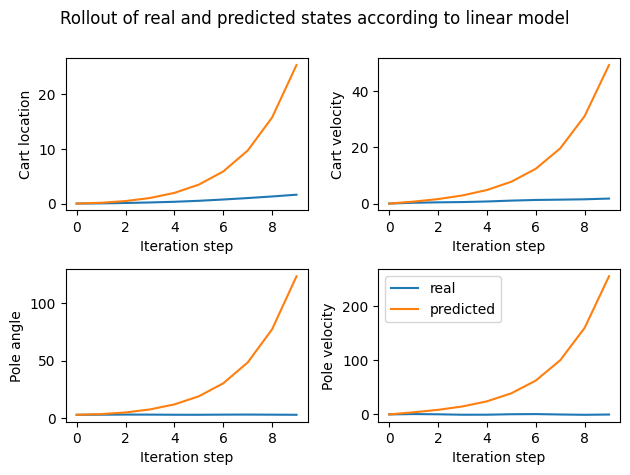

In [151]:
### TASK 2.2 LINEAR WITH ACTION

# function to generate the OLS matrix given a list of (X,Y) datapoints. each X has length 5
def find_OLS_matrix_with_Action(list_of_X_Y_tuples):

    # initiate empty X and Y matrices where each row will contain each X, Y datapoint
    X = np.zeros((len(list_of_X_Y_tuples), 5))
    Y = np.zeros((len(list_of_X_Y_tuples), 4))

    # populate X and Y matrices' rows with datapoints
    for i in range(len(list_of_X_Y_tuples)):
        X[i] = list_of_X_Y_tuples[i][0]
        Y[i] = list_of_X_Y_tuples[i][1]
    
    # find OLS matrix so solve the equation: Y=CX
    C = np.linalg.lstsq(X, Y, rcond=None)[0]

    return C


# function to plot actual Y against predicted Y for linear model with action; Y is the change in state and is 4D
def plot_realY_against_predY_according_to_linear_model(list_of_X_Y_tuples, C):

    # initialise empty lists into which values to plot will go
    actual_Y_x_to_plot = []
    actual_Y_xdot_to_plot = []
    actual_Y_theta_to_plot = []
    actual_Y_thetadot_to_plot = []
    pred_Y_x_to_plot = []
    pred_Y_xdot_to_plot = []
    pred_Y_theta_to_plot = []
    pred_Y_thetadot_to_plot = []


    # iterate over list of X,Y tuples and populate lists of real values to plot
    for XY_tuple in list_of_X_Y_tuples:

        # get current X and Y state vectors
        X = XY_tuple[0]
        Y = XY_tuple[1]

        # populate lists to plot
        actual_Y_x_to_plot.append(Y[0])
        actual_Y_xdot_to_plot.append(Y[1])
        actual_Y_theta_to_plot.append(Y[2])
        actual_Y_thetadot_to_plot.append(Y[3])


        # find predicted Y
        Y_predict_vector = np.matmul(X, C)

        # populate lists to plot
        pred_Y_x_to_plot.append(Y_predict_vector[0])
        pred_Y_xdot_to_plot.append(Y_predict_vector[1])
        pred_Y_theta_to_plot.append(Y_predict_vector[2])
        pred_Y_thetadot_to_plot.append(Y_predict_vector[3])
    
    
    # plot graphs
    plt.subplot(2, 2, 1)
    plt.scatter(actual_Y_x_to_plot, pred_Y_x_to_plot, s=10)
    plt.title(r'$\Delta x$')
    plt.xlabel(r'$Actual\ \Delta x$')
    plt.ylabel(r'$Predicted\ \Delta x$')
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)

    plt.subplot(2, 2, 2)
    plt.scatter(actual_Y_xdot_to_plot, pred_Y_xdot_to_plot, s=10)
    plt.title(r'$\Delta \dot{x}$')
    plt.xlabel(r'$Actual\ \Delta \dot{x}$')
    plt.ylabel(r'$Predicted\ \Delta \dot{x}$')
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)

    plt.subplot(2, 2, 3)
    plt.scatter(actual_Y_theta_to_plot, pred_Y_theta_to_plot, s=10)
    plt.title(r'$\Delta \theta$')
    plt.xlabel(r'$Actual\ \Delta \theta$')
    plt.ylabel(r'$Predicted\ \Delta \theta$')
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)


    plt.subplot(2, 2, 4)
    plt.scatter(actual_Y_thetadot_to_plot, pred_Y_thetadot_to_plot, s=10)
    plt.title(r'$\Delta \dot{\theta}$')
    plt.xlabel(r'$Actual\ \Delta \dot{\theta}$')
    plt.ylabel(r'$Predicted\ \Delta \dot{\theta}$')
    plt.xlim(-9, 9)
    plt.ylim(-9, 9)
    
    plt.suptitle('Graphs of actual changes in state variables against predicted changes \n in state variables according to linear model with action')
    plt.tight_layout()
    plt.show() 


# function to plot 1D scans -> doing for case of small oscillations
def plot_1D_scans_linear_model_with_action(C, constant_state):

    # create instance of cartpole
    pendulum = CartPole()

    # initialise constant state variables for ROTATIONS
    constant_cart_location = constant_state[0]
    constant_cart_velocity = constant_state[1]
    constant_pole_angle = constant_state[2]
    constant_pole_velocity = constant_state[3]
    constant_action = constant_state[4]

    # initialise lists corresponding to state variables to scan over
    list_of_ranges = [9, 10, np.pi, 15, 4]
    list_of_xlabels = ["Initial cart location", "Initial cart velocity", "Initial pole angle", "Initial pole velocity", "Action"]
    list_of_subtitles = ["Scans of cart location", "Scans of cart velocity", "Scans of pole angle", "Scans of pole velocity", "Linear model: scans of action"]

    # looking over 5 different state variables
    for index_of_state_variable_we_scan_over in range(0,5):

        # get array of values to test in our scan
        x = list_of_ranges[index_of_state_variable_we_scan_over]
        variable_to_scan = np.linspace(-x,x,20)

        # initialise state vector
        state = [constant_cart_location, constant_cart_velocity, constant_pole_angle, constant_pole_velocity, constant_action]

        # intialise empty lists into which actual values of Y state varialbes will go
        actual_Y_cart_locations_to_plot = []
        actual_Y_cart_velocities_to_plot = []
        actual_Y_pole_angles_to_plot = []
        actual_Y_pole_velocities_to_plot = []

        # initialise empty lists into which predicted values of Y state variables will go
        pred_Y_cart_locations_to_plot = []
        pred_Y_cart_velocities_to_plot = []
        pred_Y_pole_angles_to_plot = []
        pred_Y_pole_velocities_to_plot = []

        # loop over values the variable which is being scanned takes
        for variable_to_scan_value in variable_to_scan:

            # update state vector
            state[index_of_state_variable_we_scan_over] = variable_to_scan_value

            # get actual Y (new_state)
            pendulum.setState(state[:4])
            pendulum.performAction(state[4])
            new_state = pendulum.getState()
            actual_Y = new_state - state[:4]

            # append actual Y values to lists
            actual_Y_cart_locations_to_plot.append(actual_Y[0])
            actual_Y_cart_velocities_to_plot.append(actual_Y[1])
            actual_Y_pole_angles_to_plot.append(actual_Y[2])
            actual_Y_pole_velocities_to_plot.append(actual_Y[3])

            # get predicted Y
            pred_Y = np.matmul(state, C)

            # append predicted Y values to lists
            pred_Y_cart_locations_to_plot.append(pred_Y[0])
            pred_Y_cart_velocities_to_plot.append(pred_Y[1])
            pred_Y_pole_angles_to_plot.append(pred_Y[2])
            pred_Y_pole_velocities_to_plot.append(pred_Y[3])
                    


        # plot graphs
        plt.subplot(2, 2, 1)
        plt.plot(variable_to_scan, actual_Y_cart_locations_to_plot, label="Actual")
        plt.plot(variable_to_scan, pred_Y_cart_locations_to_plot, label="Predicted")
        plt.title("Cart location")
        plt.xlabel(list_of_xlabels[index_of_state_variable_we_scan_over])
        plt.ylabel("Change in cart location")
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(variable_to_scan, actual_Y_cart_velocities_to_plot, label="Actual")
        plt.plot(variable_to_scan, pred_Y_cart_velocities_to_plot, label="Predicted")
        plt.title("Cart velocity")
        plt.xlabel(list_of_xlabels[index_of_state_variable_we_scan_over])
        plt.ylabel("Change in cart velocity")
        plt.legend()

        plt.subplot(2, 2, 3)
        plt.plot(variable_to_scan, actual_Y_pole_angles_to_plot, label="Actual")
        plt.plot(variable_to_scan, pred_Y_pole_angles_to_plot, label="Predicted")
        plt.title("Pole angle")
        plt.xlabel(list_of_xlabels[index_of_state_variable_we_scan_over])
        plt.ylabel("Change in pole angle")
        plt.legend()

        plt.subplot(2, 2, 4)
        plt.plot(variable_to_scan, actual_Y_pole_velocities_to_plot, label="Actual")
        plt.plot(variable_to_scan, pred_Y_pole_velocities_to_plot, label="Predicted")
        plt.title("Pole velocity")
        plt.xlabel(list_of_xlabels[index_of_state_variable_we_scan_over])
        plt.ylabel("Change in pole velocity")
        plt.legend()

        plt.suptitle(list_of_subtitles[index_of_state_variable_we_scan_over])
        plt.tight_layout()
        plt.show()


# function to plot 2D scans of state variables using linear model with action
def plot_2D_scans_linear_model_with_action(C, no_increments=20):

    # initialise lists corresponding to state variables to scan over: cart.loc = 9, cart.vel = 10, pole.angle = pi, pole.vel = 15, action = 4
    list_of_ranges = [[9, 10], [9, np.pi], [9, 15], [9, 4], [10, np.pi], [10, 15], [10, 4], [np.pi, 15], [np.pi, 4], [15, 4]]

    # create lists of x and y labels and suptitles
    x_labels = ["Cart location", "Cart location", "Cart location", "Cart location", "Cart velocity", "Cart velocity", "Cart velocity", "Pole angle", "Pole angle", "Pole velocity"]
    y_labels = ["Cart velocity", "Pole angle", "Pole velocity", "Action", "Pole angle", "Pole velocity", "Action", "Pole velocity", "Action", "Action"]
    suptitles = ["Scans of cart location and cart velocity", "Scans of cart location and pole angle", "Scans of cart location and pole velocity", "Scans of cart location and action", "Scans of cart velocity and pole angle", "Scans of cart velocity and pole velocity", "Scans of cart velocity and action", "Scans of pole angle and pole velocity", "Scans of pole angle and action", "Linear model: scans of pole velocity and action"]

    # initialise constant state variables
    constant_cart_location = constant_state[0]
    constant_cart_velocity = constant_state[1]
    constant_pole_angle = constant_state[2]
    constant_pole_velocity = constant_state[3]
    constant_action = constant_state[4]

    # looking over 10 different combinations of state variables
    for index_of_state_variables_we_scan_over in range(0, 10):

        # get array of values to test in our scan
        x = list_of_ranges[index_of_state_variables_we_scan_over][0]
        y = list_of_ranges[index_of_state_variables_we_scan_over][1]
        array_of_values_of_variable_to_scan_x = np.linspace(-x, x, no_increments)
        array_of_values_of_variable_to_scan_y = np.linspace(-y, y, no_increments)

        # initialise state vector
        state = [constant_cart_location, constant_cart_velocity, constant_pole_angle, constant_pole_velocity, constant_action]

        # initialise empty lists into which predicted Y values will go
        pred_Y_cart_locations_to_plot = []
        pred_Y_cart_velocities_to_plot = []
        pred_Y_pole_angles_to_plot = []
        pred_Y_pole_velocities_to_plot = []

        # TRY THIS
        array_of_values_of_variable_to_scan_x, array_of_values_of_variable_to_scan_y = np.meshgrid(array_of_values_of_variable_to_scan_x, array_of_values_of_variable_to_scan_y)
        array_of_values_of_variable_to_scan_x = array_of_values_of_variable_to_scan_x.flatten()
        array_of_values_of_variable_to_scan_y = array_of_values_of_variable_to_scan_y.flatten()
        triangulation = tri.Triangulation(array_of_values_of_variable_to_scan_x, array_of_values_of_variable_to_scan_y)

        # loop over values the variable which is being scanned takes
        # for i in range(0, no_increments): GOT RID OF THIS BC TRYING A THING OUT
        for i, (xi, yi) in enumerate(zip(array_of_values_of_variable_to_scan_x, array_of_values_of_variable_to_scan_y)):

            # update state vector
            if index_of_state_variables_we_scan_over == 0: # scanning over cart location and cart velocity
                state[0] = array_of_values_of_variable_to_scan_x[i]
                state[1] = array_of_values_of_variable_to_scan_y[i]
            
            elif index_of_state_variables_we_scan_over == 1: # scanning over cart location and pole angle
                state[0] = array_of_values_of_variable_to_scan_x[i]
                state[2] = array_of_values_of_variable_to_scan_y[i]
            
            elif index_of_state_variables_we_scan_over == 2: # scanning over cart location and pole velocity
                state[0] = array_of_values_of_variable_to_scan_x[i]
                state[3] = array_of_values_of_variable_to_scan_y[i]
            
            elif index_of_state_variables_we_scan_over == 3: # scanning over cart location and action
                state[0] = array_of_values_of_variable_to_scan_x[i]
                state[4] = array_of_values_of_variable_to_scan_y[i]
            
            elif index_of_state_variables_we_scan_over == 4: # scanning over cart velocity and pole angle
                state[1] = array_of_values_of_variable_to_scan_x[i]
                state[2] = array_of_values_of_variable_to_scan_y[i]
            
            elif index_of_state_variables_we_scan_over == 5: # scanning over cart velocity and pole velocity
                state[1] = array_of_values_of_variable_to_scan_x[i]
                state[3] = array_of_values_of_variable_to_scan_y[i]
            
            elif index_of_state_variables_we_scan_over == 6: # scanning over cart velocity and action
                state[1] = array_of_values_of_variable_to_scan_x[i]
                state[4] = array_of_values_of_variable_to_scan_y[i]
            
            elif index_of_state_variables_we_scan_over == 7: # scanning over pole angle and pole velocity
                state[2] = array_of_values_of_variable_to_scan_x[i]
                state[3] = array_of_values_of_variable_to_scan_y[i]
            
            elif index_of_state_variables_we_scan_over == 8: # scanning over pole angle and action
                state[2] = array_of_values_of_variable_to_scan_x[i]
                state[4] = array_of_values_of_variable_to_scan_y[i]
            
            elif index_of_state_variables_we_scan_over == 9: # scanning over pole velocity and action
                state[3] = array_of_values_of_variable_to_scan_x[i]
                state[4] = array_of_values_of_variable_to_scan_y[i]
            
            else:
                print("error")
            
            
            # get predicted Y accoring to the linear model
            pred_Y = np.matmul(state, C)


            # append predicted Y values to lists
            pred_Y_cart_locations_to_plot.append(pred_Y[0])
            pred_Y_cart_velocities_to_plot.append(pred_Y[1])
            pred_Y_pole_angles_to_plot.append(pred_Y[2])
            pred_Y_pole_velocities_to_plot.append(pred_Y[3])



        ## Plot the filled contour

        # Create subplots
        fig, axs = plt.subplots(2, 2)

        # plot cart locations
        axs[0, 0].tricontourf(triangulation, pred_Y_cart_locations_to_plot)
        axs[0, 0].set_xlabel(x_labels[index_of_state_variables_we_scan_over])
        axs[0, 0].set_ylabel(y_labels[index_of_state_variables_we_scan_over])
        axs[0, 0].set_title('Change in cart location')
        fig.colorbar(axs[0, 0].collections[0], ax=axs[0, 0])

        # plot cart velocities
        axs[0, 1].tricontourf(triangulation, pred_Y_cart_velocities_to_plot)
        axs[0, 1].set_xlabel(x_labels[index_of_state_variables_we_scan_over])
        axs[0, 1].set_ylabel(y_labels[index_of_state_variables_we_scan_over])
        axs[0, 1].set_title('Change in cart velocity')
        fig.colorbar(axs[0, 1].collections[0], ax=axs[0, 1])

        # plot pole angles
        axs[1, 0].tricontourf(triangulation, pred_Y_pole_angles_to_plot)
        axs[1, 0].set_xlabel(x_labels[index_of_state_variables_we_scan_over])
        axs[1, 0].set_ylabel(y_labels[index_of_state_variables_we_scan_over])
        axs[1, 0].set_title('Change in pole angle')
        fig.colorbar(axs[1, 0].collections[0], ax=axs[1, 0])

        # plot pole velocities
        axs[1, 1].tricontourf(triangulation, pred_Y_pole_velocities_to_plot)
        axs[1, 1].set_xlabel(x_labels[index_of_state_variables_we_scan_over])
        axs[1, 1].set_ylabel(y_labels[index_of_state_variables_we_scan_over])
        axs[1, 1].set_title('Change in pole velocity')
        fig.colorbar(axs[1, 1].collections[0], ax=axs[1, 1])

        fig.suptitle(suptitles[index_of_state_variables_we_scan_over])
        fig.tight_layout()
        plt.show()


# function to plot rollouts: plotting real next step and predicted next step (according to linear model) against time
# initial state should be of length 5, the action value should be equal to the first element in list_of_actioins
def plot_rollout_real_and_predicted_according_to_linear_model_with_action(initial_state, no_steps, C, list_of_actions=None):

    print(initial_state)

    # initialsie instance of cartpole
    pendulum = CartPole()

    # initialise list of iteration steps
    iteration_steps = list(range(no_steps))

    # initialise empty list into which real states, predicted states will go
    pred_cart_locations = [initial_state[0]]
    pred_cart_velocities = [initial_state[1]]
    pred_pole_angles = [initial_state[2]]
    pred_pole_velocities = [initial_state[3]]
    real_cart_locations = [initial_state[0]]
    real_cart_velocities = [initial_state[1]]
    real_pole_angles = [initial_state[2]]
    real_pole_velocities = [initial_state[3]]

    actual_state = initial_state
    pred_state = initial_state

    # if no actions inputted, same as saying they are all 0
    if list_of_actions is None:
        list_of_actions = np.zeros(no_steps)

    # loop over iteration steps
    for it in iteration_steps:

        # looking for the next state
        it += 1
        if it >= no_steps:
            break
  
        # get next actual state
        pendulum.setState(actual_state[:4])
        pendulum.performAction(actual_state[4])
        next_actual_state = pendulum.getState()
        next_actual_state = np.append(next_actual_state, list_of_actions[it]) # add action to state


        # get next predicted state
        # pred_state has dimension 5, C has dimension 5x5
        pred_change_in_state = np.matmul(pred_state, C)
        next_pred_state = add_lists(pred_state[:4], pred_change_in_state)
        next_pred_state.append(list_of_actions[it])

        # append states to lists
        pred_cart_locations.append(next_pred_state[0])
        pred_cart_velocities.append(next_pred_state[1])
        pred_pole_angles.append(next_pred_state[2])
        pred_pole_velocities.append(next_pred_state[3])
        real_cart_locations.append(next_actual_state[0])
        real_cart_velocities.append(next_actual_state[1])
        real_pole_angles.append(next_actual_state[2])
        real_pole_velocities.append(next_actual_state[3])
        
        # update current state ready for next iteration
        actual_state = next_actual_state
        pred_state = next_pred_state
    

    # plot the rollouts
    plt.subplot(2, 2, 1)
    plt.plot(iteration_steps, real_cart_locations, label='real')
    plt.plot(iteration_steps, pred_cart_locations, label='predicted')
    plt.xlabel('Iteration step')
    plt.ylabel('Cart location')
    plt.title('\n')
    #plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(iteration_steps, real_cart_velocities, label='real')
    plt.plot(iteration_steps, pred_cart_velocities, label='predicted')
    plt.xlabel('Iteration step')
    plt.ylabel('Cart velocity')
    plt.title('\n')
    #plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(iteration_steps, real_pole_angles, label='real')
    plt.plot(iteration_steps, pred_pole_angles, label='predicted')
    plt.xlabel('Iteration step')
    plt.ylabel('Pole angle')
    #plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(iteration_steps, real_pole_velocities, label='real')
    plt.plot(iteration_steps, pred_pole_velocities, label='predicted')
    plt.xlabel('Iteration step')
    plt.ylabel('Pole velocity')
    plt.legend()

    plt.tight_layout()
    plt.suptitle('Rollout of real and predicted states according to linear model') # add in if oscillations or rotations
    plt.show()




# get data with actions
num_datapoints = 400
array_of_X_Y_datapoints_with_action = make_array_of_XY_datapoints(num_datapoints, want_actions=True)



constant_state = [2, 2, np.pi + 0.1, -1, 10] # oscillations
#constant_state = [2, 2, np.pi + 0.1, 10, 1] # rotations
constant_state = [0, 1, 0.1, 0.1, 0] # slightly perterbed from verticaly upwards
initial_state = [0, 0, np.pi, 0, 1] # down
no_steps = 10 # for rollout

list_of_actions = np.ones(no_steps)

C = find_OLS_matrix_with_Action(array_of_X_Y_datapoints_with_action) # C is 5x4
# plot_realY_against_predY_according_to_linear_model(array_of_X_Y_datapoints_with_action, C)
# plot_1D_scans_linear_model_with_action(C, constant_state)
# plot_2D_scans_linear_model_with_action(C, no_increments=20)
plot_rollout_real_and_predicted_according_to_linear_model_with_action(initial_state, no_steps, C, list_of_actions)


68.22778082890187 -874.5977490752748 163.80952052192777 -1952.4972485578971


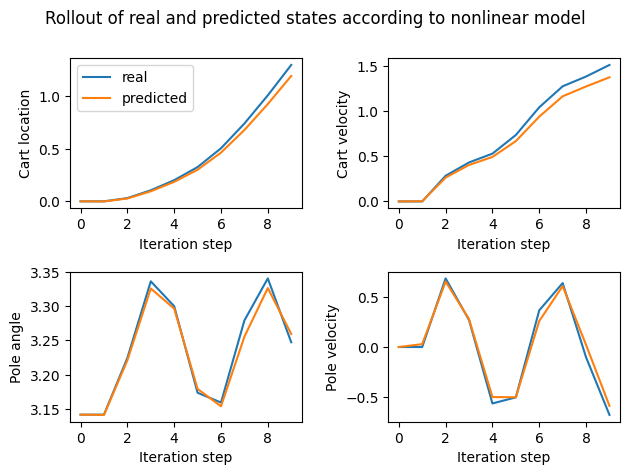

In [28]:
### TASK 2.2 NONLINEAR WITH ACTION
# function to plot actual Y against predicted Y for nonlinear model with action; Y is the change in state and is 4D
def plot_realY_against_predY_according_to_nonlinear_model(list_of_X_Y_tuples, num_basis_centres, alpha_x, alpha_xdot, alpha_theta, alpha_thetadot, sigma):

    # initialise empty lists into which values to plot will go
    actual_Y_x_to_plot = []
    actual_Y_xdot_to_plot = []
    actual_Y_theta_to_plot = []
    actual_Y_thetadot_to_plot = []
    pred_Y_x_to_plot = []
    pred_Y_xdot_to_plot = []
    pred_Y_theta_to_plot = []
    pred_Y_thetadot_to_plot = []


    # iterate over list of X,Y tuples and populate lists of real values to plot
    for XY_tuple in list_of_X_Y_tuples:

        # get current X and Y state vectors
        X = XY_tuple[0]
        Y = XY_tuple[1]

        # populate lists to plot
        actual_Y_x_to_plot.append(Y[0])
        actual_Y_xdot_to_plot.append(Y[1])
        actual_Y_theta_to_plot.append(Y[2])
        actual_Y_thetadot_to_plot.append(Y[3])


        # find predicted Y
        Y_predict_vector = find_Y_given_X_according_to_nonlinear_model(X, num_basis_centres, alpha_x, alpha_xdot, alpha_theta, alpha_thetadot, sigma)

        # populate lists to plot
        pred_Y_x_to_plot.append(Y_predict_vector[0])
        pred_Y_xdot_to_plot.append(Y_predict_vector[1])
        pred_Y_theta_to_plot.append(Y_predict_vector[2])
        pred_Y_thetadot_to_plot.append(Y_predict_vector[3])
    
    
    # plot graphs
    plt.subplot(2, 2, 1)
    plt.scatter(actual_Y_x_to_plot, pred_Y_x_to_plot, s=10)
    plt.title(r'$\Delta x$')
    plt.xlabel(r'$Actual\ \Delta x$')
    plt.ylabel(r'$Predicted\ \Delta x$')
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)

    plt.subplot(2, 2, 2)
    plt.scatter(actual_Y_xdot_to_plot, pred_Y_xdot_to_plot, s=10)
    plt.title(r'$\Delta \dot{x}$')
    plt.xlabel(r'$Actual\ \Delta \dot{x}$')
    plt.ylabel(r'$Predicted\ \Delta \dot{x}$')
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)

    plt.subplot(2, 2, 3)
    plt.scatter(actual_Y_theta_to_plot, pred_Y_theta_to_plot, s=10)
    plt.title(r'$\Delta \theta$')
    plt.xlabel(r'$Actual\ \Delta \theta$')
    plt.ylabel(r'$Predicted\ \Delta \theta$')
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)


    plt.subplot(2, 2, 4)
    plt.scatter(actual_Y_thetadot_to_plot, pred_Y_thetadot_to_plot, s=10)
    plt.title(r'$\Delta \dot{\theta}$')
    plt.xlabel(r'$Actual\ \Delta \dot{\theta}$')
    plt.ylabel(r'$Predicted\ \Delta \dot{\theta}$')
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    
    plt.suptitle('Graphs of actual changes in state variables against predicted changes \n in state variables according to nonlinear model with action')
    plt.tight_layout()
    plt.show() 



# 1D scans for non-linear model. done for the case of complete rotations

# function to plot 1D scans -> doing for case of small oscillations
def plot_1D_scans_nonlinear_model_with_action(num_basis_centres, alpha_x, alpha_xdot, alpha_theta, alpha_thetadot, sigma, constant_state):

    # create instance of cartpole
    pendulum = CartPole()

    # initialise constant state variables for ROTATIONS
    constant_cart_location = constant_state[0]
    constant_cart_velocity = constant_state[1]
    constant_pole_angle = constant_state[2]
    constant_pole_velocity = constant_state[3]
    constant_action = constant_state[4]

    # initialise lists corresponding to state variables to scan over
    list_of_ranges = [9, 10, np.pi, 15, 4]
    list_of_xlabels = ["Initial cart location", "Initial cart velocity", "Initial pole angle", "Initial pole velocity", "Action"]
    list_of_subtitles = ["Scans of cart location", "Scans of cart velocity", "Scans of pole angle", "Scans of pole velocity", "Nonlinear model: scans of action"]

    # looking over 5 different state variables
    for index_of_state_variable_we_scan_over in range(0,5):

        # get array of values to test in our scan
        x = list_of_ranges[index_of_state_variable_we_scan_over]
        variable_to_scan = np.linspace(-x,x,20)

        # initialise state vector
        state = [constant_cart_location, constant_cart_velocity, constant_pole_angle, constant_pole_velocity, constant_action]

        # intialise empty lists into which actual values of Y state varialbes will go
        actual_Y_cart_locations_to_plot = []
        actual_Y_cart_velocities_to_plot = []
        actual_Y_pole_angles_to_plot = []
        actual_Y_pole_velocities_to_plot = []

        # initialise empty lists into which predicted values of Y state variables will go
        pred_Y_cart_locations_to_plot = []
        pred_Y_cart_velocities_to_plot = []
        pred_Y_pole_angles_to_plot = []
        pred_Y_pole_velocities_to_plot = []

        # loop over values the variable which is being scanned takes
        for variable_to_scan_value in variable_to_scan:

            # update state vector
            state[index_of_state_variable_we_scan_over] = variable_to_scan_value

            # get actual Y (new_state)
            pendulum.setState(state[:4])
            pendulum.performAction(state[4])
            new_state = pendulum.getState()
            actual_Y = new_state - state[:4]

            # append actual Y values to lists
            actual_Y_cart_locations_to_plot.append(actual_Y[0])
            actual_Y_cart_velocities_to_plot.append(actual_Y[1])
            actual_Y_pole_angles_to_plot.append(actual_Y[2])
            actual_Y_pole_velocities_to_plot.append(actual_Y[3])

            # get predicted Y
            pred_Y = find_Y_given_X_according_to_nonlinear_model(state, num_basis_centres, alpha_x, alpha_xdot, alpha_theta, alpha_thetadot, sigma) 

            # append predicted Y values to lists
            pred_Y_cart_locations_to_plot.append(pred_Y[0])
            pred_Y_cart_velocities_to_plot.append(pred_Y[1])
            pred_Y_pole_angles_to_plot.append(pred_Y[2])
            pred_Y_pole_velocities_to_plot.append(pred_Y[3])
                    


        # plot graphs
        plt.subplot(2, 2, 1)
        plt.plot(variable_to_scan, actual_Y_cart_locations_to_plot, label="Actual")
        plt.plot(variable_to_scan, pred_Y_cart_locations_to_plot, label="Predicted")
        plt.title("Cart location")
        plt.xlabel(list_of_xlabels[index_of_state_variable_we_scan_over])
        plt.ylabel("Change in cart location")
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(variable_to_scan, actual_Y_cart_velocities_to_plot, label="Actual")
        plt.plot(variable_to_scan, pred_Y_cart_velocities_to_plot, label="Predicted")
        plt.title("Cart velocity")
        plt.xlabel(list_of_xlabels[index_of_state_variable_we_scan_over])
        plt.ylabel("Change in cart velocity")
        plt.legend()

        plt.subplot(2, 2, 3)
        plt.plot(variable_to_scan, actual_Y_pole_angles_to_plot, label="Actual")
        plt.plot(variable_to_scan, pred_Y_pole_angles_to_plot, label="Predicted")
        plt.title("Pole angle")
        plt.xlabel(list_of_xlabels[index_of_state_variable_we_scan_over])
        plt.ylabel("Change in pole angle")
        plt.legend()

        plt.subplot(2, 2, 4)
        plt.plot(variable_to_scan, actual_Y_pole_velocities_to_plot, label="Actual")
        plt.plot(variable_to_scan, pred_Y_pole_velocities_to_plot, label="Predicted")
        plt.title("Pole velocity")
        plt.xlabel(list_of_xlabels[index_of_state_variable_we_scan_over])
        plt.ylabel("Change in pole velocity")
        plt.legend()

        plt.suptitle(list_of_subtitles[index_of_state_variable_we_scan_over])
        plt.tight_layout()
        plt.show()


# function to plot 2D scans of state variables using non-linear model with action
def plot_2D_scans_nonlinear_model_with_action(num_basis_centres, alpha_x, alpha_xdot, alpha_theta, alpha_thetadot, sigma, constant_state, no_increments=20):

    # initialise lists corresponding to state variables to scan over: cart.loc = 9, cart.vel = 10, pole.angle = pi, pole.vel = 15, action = 4
    list_of_ranges = [[9, 10], [9, np.pi], [9, 15], [9, 4], [10, np.pi], [10, 15], [10, 4], [np.pi, 15], [np.pi, 4], [15, 4]]

    # create lists of x and y labels and suptitles
    x_labels = ["Cart location", "Cart location", "Cart location", "Cart location", "Cart velocity", "Cart velocity", "Cart velocity", "Pole angle", "Pole angle", "Pole velocity"]
    y_labels = ["Cart velocity", "Pole angle", "Pole velocity", "Action", "Pole angle", "Pole velocity", "Action", "Pole velocity", "Action", "Action"]
    suptitles = ["Scans of cart location and cart velocity", "Scans of cart location and pole angle", "Scans of cart location and pole velocity", "Scans of cart location and action", "Scans of cart velocity and pole angle", "Scans of cart velocity and pole velocity", "Scans of cart velocity and action", "Scans of pole angle and pole velocity", "Scans of pole angle and action", "Nonlinear model: scans of pole velocity and action"]

    # initialise constant state variables
    constant_cart_location = constant_state[0]
    constant_cart_velocity = constant_state[1]
    constant_pole_angle = constant_state[2]
    constant_pole_velocity = constant_state[3]
    constant_action = constant_state[4]

    # looking over 10 different combinations of state variables
    for index_of_state_variables_we_scan_over in range(0, 10):

        # get array of values to test in our scan
        x = list_of_ranges[index_of_state_variables_we_scan_over][0]
        y = list_of_ranges[index_of_state_variables_we_scan_over][1]
        array_of_values_of_variable_to_scan_x = np.linspace(-x, x, no_increments)
        array_of_values_of_variable_to_scan_y = np.linspace(-y, y, no_increments)

        # initialise state vector
        state = [constant_cart_location, constant_cart_velocity, constant_pole_angle, constant_pole_velocity, constant_action]

        # initialise empty lists into which predicted Y values will go
        pred_Y_cart_locations_to_plot = []
        pred_Y_cart_velocities_to_plot = []
        pred_Y_pole_angles_to_plot = []
        pred_Y_pole_velocities_to_plot = []

        # TRY THIS
        array_of_values_of_variable_to_scan_x, array_of_values_of_variable_to_scan_y = np.meshgrid(array_of_values_of_variable_to_scan_x, array_of_values_of_variable_to_scan_y)
        array_of_values_of_variable_to_scan_x = array_of_values_of_variable_to_scan_x.flatten()
        array_of_values_of_variable_to_scan_y = array_of_values_of_variable_to_scan_y.flatten()
        triangulation = tri.Triangulation(array_of_values_of_variable_to_scan_x, array_of_values_of_variable_to_scan_y)

        # loop over values the variable which is being scanned takes
        # for i in range(0, no_increments): GOT RID OF THIS BC TRYING A THING OUT
        for i, (xi, yi) in enumerate(zip(array_of_values_of_variable_to_scan_x, array_of_values_of_variable_to_scan_y)):

            # update state vector
            if index_of_state_variables_we_scan_over == 0: # scanning over cart location and cart velocity
                state[0] = array_of_values_of_variable_to_scan_x[i]
                state[1] = array_of_values_of_variable_to_scan_y[i]
            
            elif index_of_state_variables_we_scan_over == 1: # scanning over cart location and pole angle
                state[0] = array_of_values_of_variable_to_scan_x[i]
                state[2] = array_of_values_of_variable_to_scan_y[i]
            
            elif index_of_state_variables_we_scan_over == 2: # scanning over cart location and pole velocity
                state[0] = array_of_values_of_variable_to_scan_x[i]
                state[3] = array_of_values_of_variable_to_scan_y[i]
            
            elif index_of_state_variables_we_scan_over == 3: # scanning over cart location and action
                state[0] = array_of_values_of_variable_to_scan_x[i]
                state[4] = array_of_values_of_variable_to_scan_y[i]
            
            elif index_of_state_variables_we_scan_over == 4: # scanning over cart velocity and pole angle
                state[1] = array_of_values_of_variable_to_scan_x[i]
                state[2] = array_of_values_of_variable_to_scan_y[i]
            
            elif index_of_state_variables_we_scan_over == 5: # scanning over cart velocity and pole velocity
                state[1] = array_of_values_of_variable_to_scan_x[i]
                state[3] = array_of_values_of_variable_to_scan_y[i]
            
            elif index_of_state_variables_we_scan_over == 6: # scanning over cart velocity and action
                state[1] = array_of_values_of_variable_to_scan_x[i]
                state[4] = array_of_values_of_variable_to_scan_y[i]
            
            elif index_of_state_variables_we_scan_over == 7: # scanning over pole angle and pole velocity
                state[2] = array_of_values_of_variable_to_scan_x[i]
                state[3] = array_of_values_of_variable_to_scan_y[i]
            
            elif index_of_state_variables_we_scan_over == 8: # scanning over pole angle and action
                state[2] = array_of_values_of_variable_to_scan_x[i]
                state[4] = array_of_values_of_variable_to_scan_y[i]
            
            elif index_of_state_variables_we_scan_over == 9: # scanning over pole velocity and action
                state[3] = array_of_values_of_variable_to_scan_x[i]
                state[4] = array_of_values_of_variable_to_scan_y[i]
            
            else:
                print("error")
            
            
            # get predicted Y accoring to the linear model
            pred_Y = find_Y_given_X_according_to_nonlinear_model(state, num_basis_centres, alpha_x, alpha_xdot, alpha_theta, alpha_thetadot, sigma)


            # append predicted Y values to lists
            pred_Y_cart_locations_to_plot.append(pred_Y[0])
            pred_Y_cart_velocities_to_plot.append(pred_Y[1])
            pred_Y_pole_angles_to_plot.append(pred_Y[2])
            pred_Y_pole_velocities_to_plot.append(pred_Y[3])



        ## Plot the filled contour

        # Create subplots
        fig, axs = plt.subplots(2, 2)

        # plot cart locations
        axs[0, 0].tricontourf(triangulation, pred_Y_cart_locations_to_plot)
        axs[0, 0].set_xlabel(x_labels[index_of_state_variables_we_scan_over])
        axs[0, 0].set_ylabel(y_labels[index_of_state_variables_we_scan_over])
        axs[0, 0].set_title('Change in cart location')
        fig.colorbar(axs[0, 0].collections[0], ax=axs[0, 0])

        # plot cart velocities
        axs[0, 1].tricontourf(triangulation, pred_Y_cart_velocities_to_plot)
        axs[0, 1].set_xlabel(x_labels[index_of_state_variables_we_scan_over])
        axs[0, 1].set_ylabel(y_labels[index_of_state_variables_we_scan_over])
        axs[0, 1].set_title('Change in cart velocity')
        fig.colorbar(axs[0, 1].collections[0], ax=axs[0, 1])

        # plot pole angles
        axs[1, 0].tricontourf(triangulation, pred_Y_pole_angles_to_plot)
        axs[1, 0].set_xlabel(x_labels[index_of_state_variables_we_scan_over])
        axs[1, 0].set_ylabel(y_labels[index_of_state_variables_we_scan_over])
        axs[1, 0].set_title('Change in pole angle')
        fig.colorbar(axs[1, 0].collections[0], ax=axs[1, 0])

        # plot pole velocities
        axs[1, 1].tricontourf(triangulation, pred_Y_pole_velocities_to_plot)
        axs[1, 1].set_xlabel(x_labels[index_of_state_variables_we_scan_over])
        axs[1, 1].set_ylabel(y_labels[index_of_state_variables_we_scan_over])
        axs[1, 1].set_title('Change in pole velocity')
        fig.colorbar(axs[1, 1].collections[0], ax=axs[1, 1])

        fig.suptitle(suptitles[index_of_state_variables_we_scan_over])
        fig.tight_layout()
        plt.show()


# function to plot rollouts: plotting real next step and predicted next step (according to linear model) against time
# initial state should be of length 5, the action value should be equal to the first element in list_of_actioins
def plot_rollout_real_and_predicted_according_to_nonlinear_model_with_action(initial_state, no_steps, num_basis_centres, alpha_x, alpha_xdot, alpha_theta, alpha_thetadot, sigma, list_of_actions=None):

    # initialsie instance of cartpole
    pendulum = CartPole()

    # initialise list of iteration steps
    iteration_steps = list(range(no_steps))

    # initialise empty list into which real states, predicted states will go
    pred_cart_locations = [initial_state[0]]
    pred_cart_velocities = [initial_state[1]]
    pred_pole_angles = [initial_state[2]]
    pred_pole_velocities = [initial_state[3]]
    real_cart_locations = [initial_state[0]]
    real_cart_velocities = [initial_state[1]]
    real_pole_angles = [initial_state[2]]
    real_pole_velocities = [initial_state[3]]

    actual_state = initial_state
    pred_state = initial_state

    # if no actions inputted, same as saying they are all 0
    if list_of_actions is None:
        list_of_actions = np.zeros(no_steps)

    # loop over iteration steps
    for it in iteration_steps:

        # looking for the next state
        it += 1
        if it >= no_steps:
            break
  
        # get next actual state
        pendulum.setState(actual_state[:4])
        pendulum.performAction(actual_state[4])
        next_actual_state = pendulum.getState()
        next_actual_state = np.append(next_actual_state, list_of_actions[it])


        # get next predicted state
        # pred_state has dimension 5, C has dimension 5x5
        pred_change_in_state = find_Y_given_X_according_to_nonlinear_model(pred_state, num_basis_centres, alpha_x, alpha_xdot, alpha_theta, alpha_thetadot, sigma)
        next_pred_state = add_lists(pred_state[:4], pred_change_in_state)
        next_pred_state.append(list_of_actions[it])

        # append states to lists
        pred_cart_locations.append(next_pred_state[0])
        pred_cart_velocities.append(next_pred_state[1])
        pred_pole_angles.append(next_pred_state[2])
        pred_pole_velocities.append(next_pred_state[3])
        real_cart_locations.append(next_actual_state[0])
        real_cart_velocities.append(next_actual_state[1])
        real_pole_angles.append(next_actual_state[2])
        real_pole_velocities.append(next_actual_state[3])
        
        # update current state ready for next iteration
        actual_state = next_actual_state
        pred_state = next_pred_state
    
    # plot the rollouts
    plt.subplot(2, 2, 1)
    plt.plot(iteration_steps, real_cart_locations, label='real')
    plt.plot(iteration_steps, pred_cart_locations, label='predicted')
    plt.xlabel('Iteration step')
    plt.ylabel('Cart location')
    plt.title('\n')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(iteration_steps, real_cart_velocities, label='real')
    plt.plot(iteration_steps, pred_cart_velocities, label='predicted')
    plt.xlabel('Iteration step')
    plt.ylabel('Cart velocity')
    plt.title('\n')
    #plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(iteration_steps, real_pole_angles, label='real')
    plt.plot(iteration_steps, pred_pole_angles, label='predicted')
    plt.xlabel('Iteration step')
    plt.ylabel('Pole angle')
   
    #plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(iteration_steps, real_pole_velocities, label='real')
    plt.plot(iteration_steps, pred_pole_velocities, label='predicted')
    plt.xlabel('Iteration step')
    plt.ylabel('Pole velocity')
  
    #plt.legend()

    #plt.subplots_adjust(top=10)
    #plt.set_size_inches(1, 1)
    plt.tight_layout()
    plt.suptitle('Rollout of real and predicted states according to nonlinear model') # add in if oscillations or rotations
    plt.show()






# get data with actions
array_of_X_Y_datapoints_with_action = make_array_of_XY_datapoints(400, want_actions=True)
array_of_X_Y_datapoints_with_action = make_array_of_XY_datapoints_with_action_with_noisy_Y(num_datapoints=500, noise_mean=0, noise_std=0)


# set hyperparameters
sigma = np.array([58.9, 63.4, 0.38, 29.6, 7])
sigma = np.array([105.2, 92.9, 0.38, 14.8, 25.2])
lamda = 10**(-3)                                      

num_basis_centres = 250
num_datapoints = 500



#constant_state = [2, 2, np.pi + 0.1, -1, 0] # oscillations
#constant_state = [2, 2, np.pi + 0.1, 10, 0] # rotations
constant_state = [0, 1, 0.1, 0.1, 0] # slightly perterbed from verticaly upwards
initial_state = [0, 0, np.pi, 0, 0] # down
no_steps = 10 # for rollout
list_of_actions = np.ones(no_steps)



# # train model to find the alpha vectors
# K_MN = get_K_MN_matrix(num_basis_centres, num_datapoints, sigma, array_of_X_Y_datapoints_with_action) 
# K_NM = K_MN.T
# K_MM = get_K_MM_matrix(num_basis_centres, sigma)
# alpha_x = get_alpha(K_MN, K_MM, lamda, array_of_X_Y_datapoints_with_action, index=0) # all these alphas correspond to the same basis vectors: use sobol sequence to get them
# alpha_xdot = get_alpha(K_MN, K_MM, lamda, array_of_X_Y_datapoints_with_action, index=1)
# alpha_theta = get_alpha(K_MN, K_MM, lamda, array_of_X_Y_datapoints_with_action, index=2)
# alpha_thetadot = get_alpha(K_MN, K_MM, lamda, array_of_X_Y_datapoints_with_action, index=3)
alpha_x, alpha_xdot, alpha_theta, alpha_thetadot = get_optimum_alpha_vectors(array_of_X_Y_datapoints_with_action, num_basis_centres, sigma, lamda)


# plot_realY_against_predY_according_to_nonlinear_model(array_of_X_Y_datapoints_with_action, num_basis_centres, alpha_x, alpha_xdot, alpha_theta, alpha_thetadot, sigma)
# plot_1D_scans_nonlinear_model_with_action(num_basis_centres, alpha_x, alpha_xdot, alpha_theta, alpha_thetadot, sigma, constant_state)
# plot_2D_scans_nonlinear_model_with_action(num_basis_centres, alpha_x, alpha_xdot, alpha_theta, alpha_thetadot, sigma, constant_state, no_increments=20)
plot_rollout_real_and_predicted_according_to_nonlinear_model_with_action(initial_state, no_steps, num_basis_centres, alpha_x, alpha_xdot, alpha_theta, alpha_thetadot, sigma, list_of_actions)

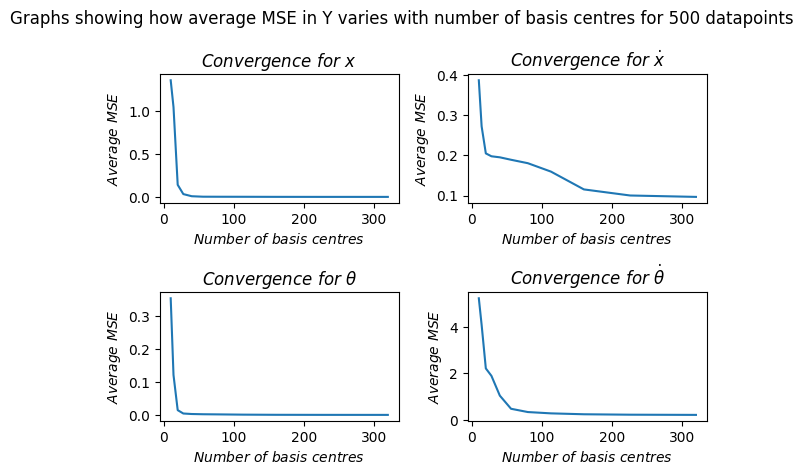

105.22342640698744 92.91952335224315 0.3770539431388136 14.843852635575143 25.158137732292854


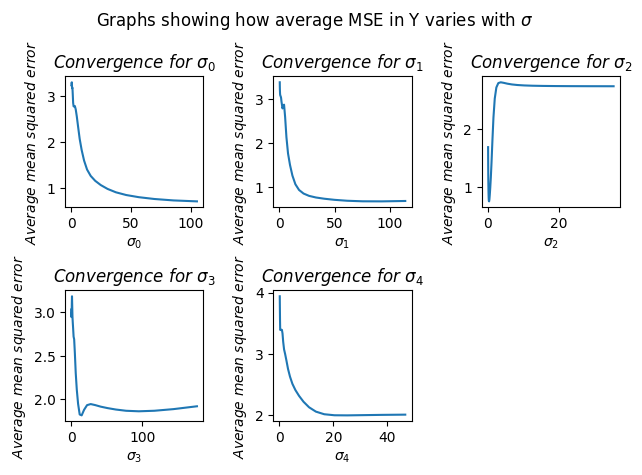

In [154]:
### PLAYING WITH OPTIMIZING HYPERPARAMETERS FOR NONLINEAR WITH ACTION



def plot_sigma_against_convergence_with_action(datapoints, num_basis_centres, lamda, proportion_of_sigma_to_test, const_sigma_values, no_increments, num_its=0):

    # create list of sigmas to test, starting with std of datapoitns USING LINEAR SCALE
    start_sigma = get_std_as_vector(datapoints)
    # sigma_0_to_test = np.linspace(start_sigma[0]*proportion_of_sigma_to_test, start_sigma[0]/proportion_of_sigma_to_test, no_increments)
    # sigma_1_to_test = np.linspace(start_sigma[1]*proportion_of_sigma_to_test, start_sigma[1]/proportion_of_sigma_to_test, no_increments)
    # sigma_2_to_test = np.linspace(start_sigma[2]*proportion_of_sigma_to_test, start_sigma[2]/proportion_of_sigma_to_test, no_increments)
    # sigma_3_to_test = np.linspace(start_sigma[3]*proportion_of_sigma_to_test, start_sigma[3]/proportion_of_sigma_to_test, no_increments)

    # create lists of sigmas to test, starting with std of datapoints USING LOG SCALE
    sigma_0_to_test = np.logspace(np.log10(start_sigma[0]*proportion_of_sigma_to_test), np.log10(start_sigma[0]/proportion_of_sigma_to_test), no_increments)
    sigma_1_to_test = np.logspace(np.log10(start_sigma[1]*proportion_of_sigma_to_test), np.log10(start_sigma[1]/proportion_of_sigma_to_test), no_increments)
    sigma_2_to_test = np.logspace(np.log10(start_sigma[2]*proportion_of_sigma_to_test), np.log10(start_sigma[2]/proportion_of_sigma_to_test), no_increments)
    sigma_3_to_test = np.logspace(np.log10(start_sigma[3]*proportion_of_sigma_to_test), np.log10(start_sigma[3]/proportion_of_sigma_to_test), no_increments)
    sigma_4_to_test = np.logspace(np.log10(start_sigma[4]*proportion_of_sigma_to_test), np.log10(start_sigma[4]/proportion_of_sigma_to_test), no_increments)

    # create empty lists into which average errors over all state variables will go
    ave_errors_for_sigma0 = []
    ave_errors_for_sigma1 = []
    ave_errors_for_sigma2 = []
    ave_errors_for_sigma3 = []
    ave_errors_for_sigma4 = []

    # testing all values of sigma0
    for sigma0 in sigma_0_to_test:

        sigma = [sigma0, const_sigma_values, const_sigma_values, const_sigma_values, const_sigma_values]

        # get and append average error over all state variables
        error_vector = get_error_between_actual_and_predicted(datapoints, num_basis_centres, sigma, lamda, num_its)
        ave_error = np.average(error_vector)
        ave_errors_for_sigma0.append(ave_error)
    
    # testing all values of sigma1
    for sigma1 in sigma_1_to_test:

        sigma = [const_sigma_values, sigma1, const_sigma_values, const_sigma_values, const_sigma_values]

        # get and append average error over all state variables
        error_vector = get_error_between_actual_and_predicted(datapoints, num_basis_centres, sigma, lamda, num_its)
        ave_error = np.average(error_vector)
        ave_errors_for_sigma1.append(ave_error)
    
    # testing all values of sigma2
    for sigma2 in sigma_2_to_test:

        sigma = [const_sigma_values, const_sigma_values, sigma2, const_sigma_values, const_sigma_values]

        # get and append average error over all state variables
        error_vector = get_error_between_actual_and_predicted(datapoints, num_basis_centres, sigma, lamda, num_its)
        ave_error = np.average(error_vector)
        ave_errors_for_sigma2.append(ave_error)
    
    # testing all values of sigma3
    for sigma3 in sigma_3_to_test:

        sigma = [const_sigma_values, const_sigma_values, const_sigma_values, sigma3, const_sigma_values]

        # get and append average error over all state variables
        error_vector = get_error_between_actual_and_predicted(datapoints, num_basis_centres, sigma, lamda, num_its)
        ave_error = np.average(error_vector)
        ave_errors_for_sigma3.append(ave_error)
    
    # testing all values of sigma4
    for sigma4 in sigma_4_to_test:

        sigma = [const_sigma_values, const_sigma_values, const_sigma_values, const_sigma_values, sigma4]

        # get and append average error over all state variables
        error_vector = get_error_between_actual_and_predicted(datapoints, num_basis_centres, sigma, lamda, num_its)
        ave_error = np.average(error_vector)
        ave_errors_for_sigma4.append(ave_error)
    
    min_index_0 = np.argmin(ave_errors_for_sigma0)
    min_index_1 = np.argmin(ave_errors_for_sigma1)
    min_index_2 = np.argmin(ave_errors_for_sigma2)
    min_index_3 = np.argmin(ave_errors_for_sigma3)
    min_index_4 = np.argmin(ave_errors_for_sigma4)
    print(sigma_0_to_test[min_index_0], sigma_1_to_test[min_index_1], sigma_2_to_test[min_index_2], sigma_3_to_test[min_index_3], sigma_4_to_test[min_index_4])
    
    # plot graphs

    plt.subplot(2, 3, 1)
    plt.plot(sigma_0_to_test, ave_errors_for_sigma0)
    plt.title(r'$Convergence\ for\ \sigma_0$')
    plt.xlabel(r'$\sigma_0$')
    plt.ylabel(r'$Average\ mean\ squared\ error$')

    plt.subplot(2, 3, 2)
    plt.plot(sigma_1_to_test, ave_errors_for_sigma1)
    plt.title(r'$Convergence\ for\ \sigma_1$')
    plt.xlabel(r'$\sigma_1$')
    plt.ylabel(r'$Average\ mean\ squared\ error$')

    plt.subplot(2, 3, 3)
    plt.plot(sigma_2_to_test, ave_errors_for_sigma2)
    plt.title(r'$Convergence\ for\ \sigma_2$')
    plt.xlabel(r'$\sigma_2$')
    plt.ylabel(r'$Average\ mean\ squared\ error$')

    plt.subplot(2, 3, 4)
    plt.plot(sigma_3_to_test, ave_errors_for_sigma3)
    plt.title(r'$Convergence\ for\ \sigma_3$')
    plt.xlabel(r'$\sigma_3$')
    plt.ylabel(r'$Average\ mean\ squared\ error$')

    plt.subplot(2, 3, 5)
    plt.plot(sigma_4_to_test, ave_errors_for_sigma4)
    plt.title(r'$Convergence\ for\ \sigma_4$')
    plt.xlabel(r'$\sigma_4$')
    plt.ylabel(r'$Average\ mean\ squared\ error$')

    if num_its == 0:
        plt.suptitle('Graphs showing how average MSE in Y varies with $\sigma$')
    
    else:
        plt.suptitle('Graphs showing how average MSE in state after ' + str(num_its) + ' iterations of model simulation varies with $\sigma$')
    plt.tight_layout()
    plt.show()

def plot_lamda_against_convergence(datapoints, no_basis_centres, sigma, num_its=0):

    # make logarithmic array of lamdas to test, testing from 10^-6 to 10^-1   ######### changed last bit to 10**1 and changed num to 5, was 12
    lamdas_to_test = np.logspace(np.log10(10**(-6)), np.log10(10**(2)), num=5, base=10)

    # initilise empty error lists into which systematic errors to plot will go
    errors_x, errors_xdot, errors_theta, errors_thetadot = [], [], [], []

    # find average systematic error for different number of basis centres
    for lamda in lamdas_to_test:
        error_vector = get_error_between_actual_and_predicted(datapoints, no_basis_centres, sigma, lamda, num_its)
        errors_x.append(error_vector[0])
        errors_xdot.append(error_vector[1])
        errors_theta.append(error_vector[2])
        errors_thetadot.append(error_vector[3])
    
    # plot graphs
    plt.subplot(2, 2, 1)
    plt.plot(lamdas_to_test, errors_x)
    plt.xscale('log')
    plt.title(r'$Convergence\ for\ x$')
    plt.xlabel(r'$\lambda$')
    plt.ylabel(r'$Average\ absolute\ error$')

    plt.subplot(2, 2, 2)
    plt.plot(lamdas_to_test, errors_xdot)
    plt.xscale('log')
    plt.title(r'$Convergence\ for\ \dot{x}$')
    plt.xlabel(r'$\lambda$')
    plt.ylabel(r'$Average\ absolute\ error$')

    plt.subplot(2, 2, 3)
    plt.plot(lamdas_to_test, errors_theta)
    plt.xscale('log')
    plt.title(r'$Convergence\ for\ \theta$')
    plt.xlabel(r'$\lambda$')
    plt.ylabel(r'$Average\ absolute\ error$')

    plt.subplot(2, 2, 4)
    plt.plot(lamdas_to_test, errors_thetadot)
    plt.xscale('log')
    plt.title(r'$Convergence\ for\ \dot{\theta}$')
    plt.xlabel(r'$\lambda$')
    plt.ylabel(r'$Average\ absolute\ error$')

    if num_its == 0:
        plt.suptitle('Graphs showing how average MSE in Y varies with $\lambda$')
    else:
        plt.suptitle('Graphs showing how average MSE in state after {} iterations of model simulation varies with $\lambda$'.format(num_its))
    plt.tight_layout()
    plt.show()



def plot_num_basis_centres_against_convergence(datapoints, sigma, lamda, num_its=0):

    no_datapoints = len(datapoints)
    
    # initialise empty list into which number of basis centres to plot will go
    num_basis_centres_to_plot = []

    # start with 10
    current_no_basis_centres = 10
    
    # populate list of number of basis centres to plot with doubling numbers until it reaches the number of datapoitns
    while current_no_basis_centres < no_datapoints:
        
        num_basis_centres_to_plot.append(int(current_no_basis_centres//1))
        current_no_basis_centres *= 2**0.5
        if current_no_basis_centres > no_datapoints/1.5:
            break
    
    # now add 2 more plots evenly spaced
    #step_size = (no_datapoints - num_basis_centres_to_plot[-1]) // 3
    #num_basis_centres_to_plot.append(num_basis_centres_to_plot[-1] + step_size)
    #num_basis_centres_to_plot.append(num_basis_centres_to_plot[-1] + step_size)    
    

    # initilise empty error lists into which systematic errors to plot will go
    errors_x, errors_xdot, errors_theta, errors_thetadot = [], [], [], []


    # find average systematic error for different number of basis centres
    for no_basis_centres in num_basis_centres_to_plot:
        
        error_vector = get_error_between_actual_and_predicted(datapoints, no_basis_centres, sigma, lamda, num_its)
        errors_x.append(error_vector[0])
        errors_xdot.append(error_vector[1])
        errors_theta.append(error_vector[2])
        errors_thetadot.append(error_vector[3])
    

    plt.subplot(2, 2, 1)
    plt.plot(num_basis_centres_to_plot, errors_x)
    plt.title(r'$Convergence\ for\ x$')
    plt.xlabel(r'$Number\ of\ basis\ centres$')
    plt.ylabel(r'$Average\ MSE$')

    plt.subplot(2, 2, 2)
    plt.plot(num_basis_centres_to_plot, errors_xdot)
    plt.title(r'$Convergence\ for\ \dot{x}$')
    plt.xlabel(r'$Number\ of\ basis\ centres$')
    plt.ylabel(r'$Average\ MSE$')

    plt.subplot(2, 2, 3)
    plt.plot(num_basis_centres_to_plot, errors_theta)
    plt.title(r'$Convergence\ for\ \theta$')
    plt.xlabel(r'$Number\ of\ basis\ centres$')
    plt.ylabel(r'$Average\ MSE$')

    plt.subplot(2, 2, 4)
    plt.plot(num_basis_centres_to_plot, errors_thetadot)
    plt.title(r'$Convergence\ for\ \dot{\theta}$')
    plt.xlabel(r'$Number\ of\ basis\ centres$')
    plt.ylabel(r'$Average\ MSE$')

    plt.suptitle('Graphs showing how average MSE in Y varies with number of basis centres for {} datapoints'.format(no_datapoints))
    plt.tight_layout()
    plt.show()

        
    
# get datapoints
num_datapoints = 500
datapoints = make_array_of_XY_datapoints(num_datapoints)

# set to reasonable values
sigma = get_std_as_vector(datapoints)
sigma = np.array([58.9, 63.4, 0.38, 29.6, 7]) # optimum
lamda = 10**(-3.5)
lamda = 10**(-2.5) # optimum


plot_num_basis_centres_against_convergence(datapoints, sigma, lamda, num_its=0)










# get datapoints with actions
num_datapoints = 400
datapoints = make_array_of_XY_datapoints(num_datapoints, want_actions=True)

# set to reasonable values
sigma = get_std_as_vector(datapoints)
num_basis_centres = 200

proportion_of_sigma_to_test = 1/20
const_sigma_values = 3 # approx. average value of the std values
no_increments = 30

lamda = 10**(-3)



plot_sigma_against_convergence_with_action(datapoints, num_basis_centres, lamda, proportion_of_sigma_to_test, const_sigma_values, no_increments, num_its=0)
#plot_lamda_against_convergence(datapoints, no_basis_centres, sigma, num_its=0)
#plot_lamda_against_convergence(datapoints, no_basis_centres, sigma, num_its=2)

